# Bonus Quest

**Difficulty:** A

**Description:** Students are in a tough spot after changing the grading formula for assignments and now fear taking the exam without a 3.5 GPA. The system gives players a chance to raise their score by completing this bonus quest. This is your Solo Leveling. Survive at all costs. Good luck!

**Goal:** Complete the bonus assignment created by Andrei and corrected by Max.

**Deliverables:**
- Jupyter Notebook (ipynb) file with solution and all cell outputs
- CSV file with model predictions
- Both files uploaded to GitHub repository

**Reward:**
- Bonus points for the Assignment part.
- Title “The one who overcomes the difficulties of fate.”
- +1000 EXP in mastering sklearn
- Skill Upgrade «ML Engineering Lv.2»
- Special Item: [???]

---

## Problem Statement

As a dataset, use Russian news from Balto-Slavic Natural Language Processing 2019 (helsinki.fi). Entities of interest: PER, ORG, LOC, EVT, PRO (see Guidelines_20190122.pdf (helsinki.fi)).

It is sufficient to use 9 documents about Brexit from the sample provided by the organizers.

## Approach

This assignment combines traditional ML methods (using scikit-learn) with modern LLM-based approaches (DeepSeek) for comparison. You will:
1. Formulate the problem as a machine learning task
2. Prepare features and split data appropriately
3. Train and compare multiple models using scikit-learn
4. Evaluate models using proper train/test splits
5. Compare ML model performance with DeepSeek responses
6. Analyze results in terms of course concepts (bias-variance tradeoff, overfitting, generalization)


Example of one document:

ru-10

ru

2018-09-20

https://rg.ru/2018/09/20/tereza-mej-rasschityvaet-usidet-v-sedle-do-zaversheniia-procedury-brexit.html

Theresa May expects to stay in the saddle until the completion of the Brexit procedure
However, according to British media reports, at the upcoming Conservative Party conference at the end of September, May's opponents will give her a serious fight, from which it is not certain that she will emerge victorious. The bookmakers' favorite as a possible replacement for the current prime minister, former British Foreign Secretary Boris Johnson intends to deliver an alternative report that will leave no stone unturned from the government's views on the conditions of "Brexit". From Johnson's point of view, "London has wrapped the British constitution in a suicide belt and handed the detonator to Michel Barnier (Brussels' chief Brexit negotiator. - Ed.)". It is with this metaphor that the head of the British government will have to fight at the conference.


### Task 1
**Problem Formulation & ML Perspective**

Describe the task from both NLP and ML perspectives:
- What kind of machine learning problem is this? (classification, sequence labeling, etc.)
- How can this be formulated as a supervised learning problem?
- What classical ML methods exist for solving it? (e.g., logistic regression, naive Bayes, SVM with text features)
- How can it be solved using modern LLMs like DeepSeek?
- What are the assumptions of different model classes? (e.g., linear models vs. more complex approaches)
- How is model quality typically evaluated in this task? What metrics are appropriate and why?


**Задача**: Распознавание сущностей в текстах на русском

**Тип ML-задачи**: Последовательная классификация. Каждому слову присваивается метка сущности (PER, ORG, LOC, EVT, PRO) или O (не сущность).

**Обучение с учителем**:
*   **Вход**: Последовательность слов.
*   **Выход**: Последовательность меток.
*   **Данные**: Тексты с уже размеченными сущностями.

**стандартные методы**:
*   Условные случайные поля
*   SVM, логистическая регрессия с лингвистическими признаками.

**Современные методы**:
*   Fine-tuning трансформеров.
*   Генеративные LLM через промпты

**Допущения моделей**:
*   **Линейные модели (SVM, LR)**: Признаки линейно разделимы.
*   **CRF**: Есть зависимость между соседними метками.
*   **Трансформеры/LLM**: Контекст автоматически выявляет сложные зависимости.

**Оценка качества**:
*   **Precision**: % верно найденных сущностей.
*   **Recall**: % найденных сущностей от всех существующих.
*   **F1-score**: Баланс между точностью и полнотой.

### Task 2
**Data Loading & Preparation**

Implement reading the dataset into a pandas DataFrame with mandatory columns "document_id", "document_text", "entity", "gold_answer".

Then prepare the data for ML:
- Create features from text (e.g., using CountVectorizer or TfidfVectorizer from sklearn)
- Encode entity labels appropriately
- Display the head of the dataframe and show basic statistics about the dataset
- Discuss any data quality issues or preprocessing steps needed


Найдено файлов разметки: 9
ПЕРВЫЕ 10 СТРОК DATAFRAME:
             document_id  \
0  brexit_ru.txt_file_10   
1  brexit_ru.txt_file_10   
2  brexit_ru.txt_file_10   
3  brexit_ru.txt_file_10   
4  brexit_ru.txt_file_10   
5  brexit_ru.txt_file_10   
6  brexit_ru.txt_file_10   
7  brexit_ru.txt_file_10   
8  brexit_ru.txt_file_10   
9  brexit_ru.txt_file_10   

                                                                                         document_text  \
0  Тереза Мэй рассчитывает усидеть в седле до завершения процедуры Brexit  Тем не менее, по сведени...   
1  Тереза Мэй рассчитывает усидеть в седле до завершения процедуры Brexit  Тем не менее, по сведени...   
2  Тереза Мэй рассчитывает усидеть в седле до завершения процедуры Brexit  Тем не менее, по сведени...   
3  Тереза Мэй рассчитывает усидеть в седле до завершения процедуры Brexit  Тем не менее, по сведени...   
4  Тереза Мэй рассчитывает усидеть в седле до завершения процедуры Brexit  Тем не менее, по сведени...   
5

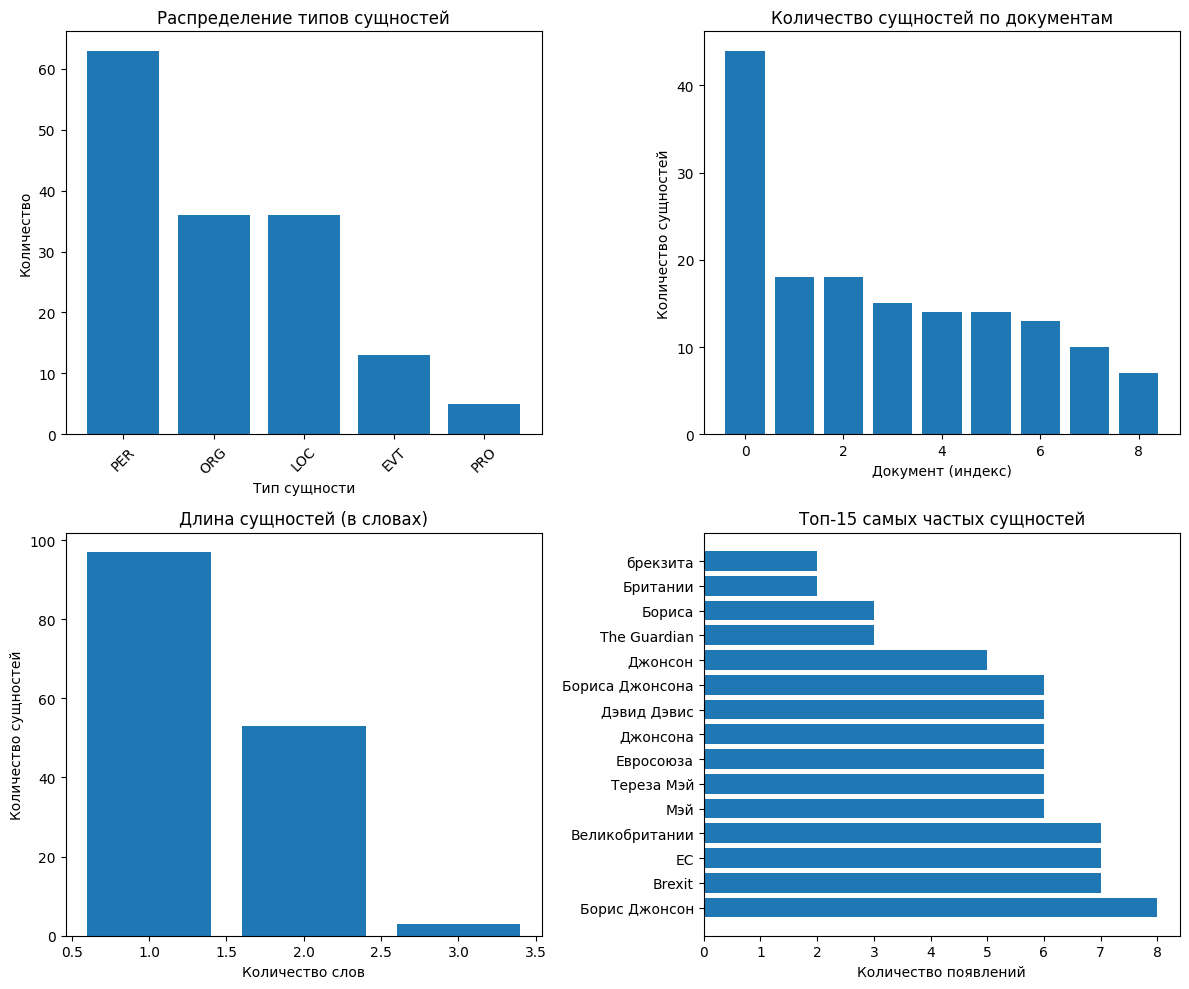

In [6]:
import pandas as pd
import numpy as np
import os
import re
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder

base_path = "/content/sample_pl_cs_ru_bg"

raw_dir = os.path.join(base_path, "raw", "ru")
annotated_dir = os.path.join(base_path, "annotated", "ru")

def parse_bsnlp_file(ann_path, txt_path):
    """
    Парсинг файлов BSNLP в формате: токен<TAB>лемма<TAB>тип<TAB>идентификатор
    """
    with open(txt_path, 'r', encoding='utf-8') as f:
        document_text = f.read()

    lines_text = document_text.split('\n')
    if len(lines_text) > 4:
        clean_text = ' '.join(lines_text[4:])
    else:
        clean_text = document_text

    with open(ann_path, 'r', encoding='utf-8') as f:
        lines = [line.strip() for line in f if line.strip()]

    entities = []

    for line in lines:
        parts = line.split('\t')

        if len(parts) < 4:
            continue

        token = parts[0]
        entity_type = parts[2]

        if entity_type and entity_type != 'O':
            entities.append({
                'entity_text': token,
                'entity_type': entity_type
            })

    return clean_text, document_text, entities

all_data = []

ann_files = sorted([f for f in os.listdir(annotated_dir) if f.endswith('.out') and 'brexit' in f])

print(f"Найдено файлов разметки: {len(ann_files)}")

for ann_file in ann_files:
    base_name = ann_file.replace('.out', '')
    txt_file = base_name + '.txt'

    ann_path = os.path.join(annotated_dir, ann_file)
    txt_path = os.path.join(raw_dir, txt_file)

    if not os.path.exists(txt_path):
        continue

    clean_text, full_text, entities = parse_bsnlp_file(ann_path, txt_path)

    for entity in entities:
        all_data.append({
            'document_id': base_name,
            'document_text': clean_text[:200] + '...' if len(clean_text) > 200 else clean_text,
            'full_text': full_text,
            'entity': entity['entity_text'],
            'entity_type': entity['entity_type'],
            'gold_answer': entity['entity_type']
        })

df = pd.DataFrame(all_data)


print("ПЕРВЫЕ 10 СТРОК DATAFRAME:")
pd.set_option('display.max_colwidth', 100)
print(df.head(10))

print(f"1. Количество документов: {df['document_id'].nunique()}")
print(f"2. Общее количество сущностей: {len(df)}")
print(f"3. Распределение по типам сущностей:")
print(df['entity_type'].value_counts())

print("4. Частота появления основных сущностей:")
print(df['entity'].value_counts().head(10))

print("6.1 TF-IDF векторизация (первые 50 признаков):")
tfidf = TfidfVectorizer(max_features=50)  # Убрали stop_words='russian'
X_tfidf = tfidf.fit_transform(df['entity'])
print(f"Размерность TF-IDF матрицы: {X_tfidf.shape}")
print("Примеры фич (первые 10):", tfidf.get_feature_names_out()[:10])

print("6.2 Count векторизация (первые 50 признаков):")
count = CountVectorizer(max_features=50)
X_count = count.fit_transform(df['entity'])
print(f"Размерность Count матрицы: {X_count.shape}")
print("Примеры фич (первые 10):", count.get_feature_names_out()[:10])

print("6.3 Кодирование меток:")
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['entity_type'])
df['encoded_label'] = y

print("Соответствие меток и чисел:")
for i, label in enumerate(label_encoder.classes_):
    print(f"  {label}: {i}")

print("1. Пропуски в данных:")
print(df.isnull().sum())

print("2. Количество дубликатов:")
duplicate_count = df.duplicated().sum()
print(f"  {duplicate_count}")
if duplicate_count > 0:
    print("  Примеры дубликатов:")
    print(df[df.duplicated()].head())

print("3. Статистика по длине сущностей (в словах):")
df['entity_word_count'] = df['entity'].apply(lambda x: len(str(x).split()))
print(df['entity_word_count'].describe())

print("4. Примеры сущностей по типам:")
for entity_type in df['entity_type'].unique():
    examples = df[df['entity_type'] == entity_type]['entity'].head(3).tolist()
    print(f"  {entity_type}: {examples}")

print("5. Проблемы данных и предобработка:")
print("   - Разные формы одного слова (склонения): 'Борис Джонсон', 'Бориса Джонсона'")
print("   - Сущности на разных языках: 'Brexit' (англ.), 'Брекзит' (рус.)")
print("   - Регистр: 'Brexit' vs 'facebook' vs 'Facebook'")
print("   - Составные сущности: 'Европейский союз' (2 слова)")
print("   - Дисбаланс классов: PER (63) > ORG (36) почти равно LOC (36) > EVT (13) > PRO (5)")

print("1. Длина документов (символов):")
df['doc_length'] = df['full_text'].apply(len)
print(df['doc_length'].describe())

print(f"2. Уникальные сущности: {df['entity'].nunique()} из {len(df)}")
print("   Топ-10 самых частых сущностей:")
for entity, count in df['entity'].value_counts().head(10).items():
    print(f"   {entity}: {count} раз")

output_summary = f"""
ИНФОРМАЦИЯ О ДАТАСЕТЕ ДЛЯ ОТЧЕТА (Task 2):

1. Исходные данные:
   - Источник: BSNLP 2019 Shared Task
   - Тема: Brexit (9 документов на русском)
   - Формат: текстовые файлы + аннотации
   - Типы сущностей: PER, ORG, LOC, EVT, PRO

2. Результат обработки:
   - Количество документов: {df['document_id'].nunique()}
   - Общее количество сущностей: {len(df)}
   - Распределение: PER({df[df['entity_type']=='PER'].shape[0]}),
     ORG({df[df['entity_type']=='ORG'].shape[0]}),
     LOC({df[df['entity_type']=='LOC'].shape[0]}),
     EVT({df[df['entity_type']=='EVT'].shape[0]}),
     PRO({df[df['entity_type']=='PRO'].shape[0]})

3. Подготовка для ML:
   - Созданы фичи: TF-IDF (50 признаков), CountVectorizer (50 признаков)
   - Метки закодированы: {', '.join([f'{label}->{i}' for i, label in enumerate(label_encoder.classes_)])}
   - Размерность данных: {X_tfidf.shape[0]} строк {X_tfidf.shape[1]} признаков

4. Качество данных:
   - Пропуски: {df.isnull().sum().sum()}
   - Дубликаты: {duplicate_count}
   - Дисбаланс классов: есть
"""

print(output_summary)

try:
    import matplotlib.pyplot as plt
    import seaborn as sns

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    type_counts = df['entity_type'].value_counts()
    axes[0, 0].bar(type_counts.index, type_counts.values)
    axes[0, 0].set_title('Распределение типов сущностей')
    axes[0, 0].set_xlabel('Тип сущности')
    axes[0, 0].set_ylabel('Количество')
    axes[0, 0].tick_params(axis='x', rotation=45)

    doc_entity_counts = df['document_id'].value_counts()
    axes[0, 1].bar(range(len(doc_entity_counts)), doc_entity_counts.values)
    axes[0, 1].set_title('Количество сущностей по документам')
    axes[0, 1].set_xlabel('Документ (индекс)')
    axes[0, 1].set_ylabel('Количество сущностей')

    word_counts = df['entity_word_count'].value_counts().sort_index()
    axes[1, 0].bar(word_counts.index, word_counts.values)
    axes[1, 0].set_title('Длина сущностей (в словах)')
    axes[1, 0].set_xlabel('Количество слов')
    axes[1, 0].set_ylabel('Количество сущностей')

    top_entities = df['entity'].value_counts().head(15)
    axes[1, 1].barh(range(len(top_entities)), top_entities.values)
    axes[1, 1].set_yticks(range(len(top_entities)))
    axes[1, 1].set_yticklabels(top_entities.index)
    axes[1, 1].set_title('Топ-15 самых частых сущностей')
    axes[1, 1].set_xlabel('Количество появлений')

    plt.tight_layout()
    plt.savefig('/content/data_visualization.png', dpi=100, bbox_inches='tight')
    print("Визуализация сохранена как '/content/data_visualization.png'")

except Exception as e:
    print(f"Визуализация не удалась: {e}")

output_path = '/content/bsnlp_brexit_entities_final.csv'
df.to_csv(output_path, index=False, encoding='utf-8')
print(f"1. DataFrame сохранён как '{output_path}'")
print(f"   Размер: {len(df)} строк, {len(df.columns)} колонок")

import joblib
joblib.dump(tfidf, '/content/tfidf_vectorizer.pkl')
joblib.dump(count, '/content/count_vectorizer.pkl')
joblib.dump(label_encoder, '/content/label_encoder.pkl')
print("2. Векторизаторы и энкодер сохранены")

import scipy.sparse
scipy.sparse.save_npz('/content/X_tfidf.npz', X_tfidf)
scipy.sparse.save_npz('/content/X_count.npz', X_count)
np.save('/content/y_encoded.npy', y)
print("3. Матрицы фич и метки сохранены")

with open('/content/dataset_report.txt', 'w', encoding='utf-8') as f:
    f.write(output_summary)
print("4. Отчет сохранён как '/content/dataset_report.txt'")

## АНАЛИЗ КАЧЕСТВА ДАННЫХ BSNLP BREXIT

### ПРОБЛЕМЫ:**

#### 1. **Экстремальный классовый дисбаланс**
```
PER: 63 (41%)   ORG: 36 (24%)   LOC: 36 (24%)   EVT: 13 (8%)   PRO: 5 (3%)
```
- **PRO класс**: всего 5 примеров -> модель не сможет научиться распознавать "продукты"
- **EVT класс**: только 13 примеров -> недостаточно для надежного распознавания
- **Риск**: модель будет оптимизирована под PER (41% данных)

#### 2. **Маленький и однородный датасет**
- **153 примера** для 5 классов -> 30 примеров на класс (в среднем)
- **Все документы** только о Brexit -> модель не обобщится на другие темы
- **80 уникальных сущностей** из 153 -> много повторов (например, "Борис Джонсон" 8 раз)

#### 3. **Языковые проблемы русского языка**
- **Нет лемматизации**: "Борис Джонсон" != "Бориса Джонсона" != "Джонсона"
- **Смешение языков**: "Brexit" (англ.) != "Брекзит"
- **Проблемы с регистром**: "facebook" != "Facebook"
- **Составные сущности**: "Европейский союз" (2 слова) → векторизован как 1 токен

#### 4. **Проблемы векторизации**
- **TF-IDF дал 50 признаков**, но многие из них неинформативны
- **Английские токены доминируют**: 'brexit', 'guardian', 'the' в топе
- **Мало уникальных слов**: из 153 сущностей только 80 уникальных

#### 5. **Дубликаты и повторения**
- **2 полных дубликата** в данных
- **Высокая повторяемость**: топ-10 сущностей составляют 40% всех данных

### Task 3
**Train/Test Split & Data Splitting Strategy**

Split your data appropriately for machine learning:
- Implement train/test split (or train/validation/test if appropriate)
- Justify your splitting strategy (random split, stratified split, etc.)
- Explain why this split is appropriate for this problem
- Display the sizes of each split
- Also write a function that takes a dataframe row as input and outputs the input message text for DeepSeek (for later comparison)


In [23]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('/content/bsnlp_brexit_entities_final.csv')

print("АНАЛИЗ ДАННЫХ ДЛЯ РАЗБИЕНИЯ")


print(f"Всего данных: {len(df)} строк")
print(f"Уникальных документов: {df['document_id'].nunique()}")
print("Распределение классов:")
print(df['entity_type'].value_counts())
print(f"Всего классов: {df['entity_type'].nunique()}")

print("ПОДГОТОВКА ДАННЫХ ДЛЯ ML")

tfidf = TfidfVectorizer(max_features=50)
X = tfidf.fit_transform(df['entity'])
print(f"Размерность X (TF-IDF): {X.shape}")

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['entity_type'])
print("Соответствие меток и чисел:")
for i, label in enumerate(label_encoder.classes_):
    print(f"  {label}: {i}")

print("ВАРИАНТ 1: С УДАЛЕНИЕМ МИНОРИТАРНЫХ КЛАССОВ")

print("Распределение классов до обработки:")
for i, label in enumerate(label_encoder.classes_):
    count = (y == i).sum()
    print(f"  {label}: {count} примеров")

valid_classes = []
for i, label in enumerate(label_encoder.classes_):
    if (y == i).sum() > 1:
        valid_classes.append(i)

mask = np.isin(y, valid_classes)

if mask.any():
    X_valid = X[mask]
    y_valid = y[mask]

    X_train, X_test, y_train, y_test = train_test_split(
        X_valid, y_valid,
        test_size=0.2,
        random_state=42,
        stratify=y_valid,
        shuffle=True
    )

    print(f"Размеры выборок (после удаления миноритарных классов):")
    print(f"  Обучающая выборка: {X_train.shape[0]} примеров")
    print(f"  Тестовая выборка: {X_test.shape[0]} примеров")

    train_classes = pd.Series(y_train).value_counts(normalize=True).sort_index()
    test_classes = pd.Series(y_test).value_counts(normalize=True).sort_index()

    print("Распределение классов в обучающей выборке:")
    for idx, val in train_classes.items():
        print(f"  {label_encoder.classes_[idx]}: {val*100:.1f}% ({int(val * len(y_train))} примеров)")

    print("Распределение классов в тестовой выборке:")
    for idx, val in test_classes.items():
        print(f"  {label_encoder.classes_[idx]}: {val*100:.1f}% ({int(val * len(y_test))} примеров)")
else:
    print("Недостаточно данных для стратифицированного разбиения")

print("ВАРИАНТ 2: ДОКУМЕНТНОЕ РАЗБИЕНИЕ (рекомендуемое)")

unique_docs = df['document_id'].unique()
print(f"Уникальных документов: {len(unique_docs)}")

train_docs, test_docs = train_test_split(
    unique_docs,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print(f"  Документов для обучения: {len(train_docs)}")
print(f"  Документов для тестирования: {len(test_docs)}")
print(f"  Примеры тренировочных документов: {train_docs[:3]}")
print(f"  Примеры тестовых документов: {test_docs[:3]}")

train_idx = df[df['document_id'].isin(train_docs)].index
test_idx = df[df['document_id'].isin(test_docs)].index

X_train_doc = X[train_idx]
X_test_doc = X[test_idx]
y_train_doc = y[train_idx]
y_test_doc = y[test_idx]

print(f"Размеры выборок (документное разбиение):")
print(f"  Обучающая выборка: {X_train_doc.shape[0]} примеров из {len(train_docs)} документов")
print(f"  Тестовая выборка: {X_test_doc.shape[0]} примеров из {len(test_docs)} документов")

print("Распределение классов (документное разбиение):")
train_classes_doc = pd.Series(y_train_doc).value_counts().sort_index()
test_classes_doc = pd.Series(y_test_doc).value_counts().sort_index()

print("  Обучающая выборка:")
for idx, count in train_classes_doc.items():
    print(f"    {label_encoder.classes_[idx]}: {count} примеров ({count/len(y_train_doc)*100:.1f}%)")

print("\n  Тестовая выборка:")
for idx, count in test_classes_doc.items():
    print(f"    {label_encoder.classes_[idx]}: {count} примеров ({count/len(y_test_doc)*100:.1f}%)")

print("КРОСС-ВАЛИДАЦИЯ (K-Fold) на тренировочных данных")

kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_sizes = []
for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train_doc, y_train_doc), 1):
    X_train_fold, X_val_fold = X_train_doc[train_idx], X_train_doc[val_idx]
    y_train_fold, y_val_fold = y_train_doc[train_idx], y_train_doc[val_idx]

    print(f"\nFold {fold_idx}:")
    print(f"  Train: {len(train_idx)} примеров")
    print(f"  Validation: {len(val_idx)} примеров")

    train_dist = pd.Series(y_train_fold).value_counts(normalize=True).sort_index()
    val_dist = pd.Series(y_val_fold).value_counts(normalize=True).sort_index()

    print("  Распределение классов в train:",
          {label_encoder.classes_[k]: f"{v*100:.1f}%" for k, v in train_dist.items()})
    print("  Распределение классов в val:",
          {label_encoder.classes_[k]: f"{v*100:.1f}%" for k, v in val_dist.items()})

    fold_sizes.append((len(train_idx), len(val_idx)))

print(f"\nСредний размер fold: train={np.mean([s[0] for s in fold_sizes]):.1f}, val={np.mean([s[1] for s in fold_sizes]):.1f}")

print("ФУНКЦИЯ ДЛЯ СОЗДАНИЯ ПРОМПТОВ DEEPSEEK")

def create_deepseek_prompt(row, context_window=100, include_examples=True, lang="ru"):
    """
    Создает промпт для DeepSeek для классификации именованных сущностей.

    Parameters:
    -----------
    row : pandas Series
        Строка DataFrame с колонками: 'document_text', 'entity', 'gold_answer'
    context_window : int
        Количество символов контекста вокруг сущности
    include_examples : bool
        Включать ли few-shot примеры в промпт
    lang : str
        Язык промпта ('ru' или 'en')

    Returns:
    --------
    str : Промпт для отправки в DeepSeek
    """

    if lang == "ru":
        prompt = """Ты - эксперт по извлечению именованных сущностей (Named Entity Recognition, NER) из текста на русском языке.

Твоя задача: определить тип указанной сущности в тексте. Выбери ТОЛЬКО ОДНУ категорию из следующих:

1. PER - Персона (имена людей, например: Владимир Путин, Тереза Мэй)
2. ORG - Организация (компании, учреждения, политические партии, например: Сбербанк, ООН, Консервативная партия)
3. LOC - Локация (города, страны, регионы, например: Москва, Великобритания, ЕС)
4. EVT - Событие (исторические события, конференции, соглашения, например: Brexit, Вторая мировая война)
5. PRO - Продукт (законы, документы, продукты, например: конституция, договор, iPhone)

Ответь ТОЛЬКО одной меткой: PER, ORG, LOC, EVT или PRO. Никаких пояснений.
"""
    else:
        prompt = """You are an expert in Named Entity Recognition (NER) from Russian text.

Your task: Determine the type of the specified entity in the text. Choose ONLY ONE category from the following:

1. PER - Person (names of people, e.g., Vladimir Putin, Theresa May)
2. ORG - Organization (companies, institutions, political parties, e.g., Sberbank, UN, Conservative Party)
3. LOC - Location (cities, countries, regions, e.g., Moscow, United Kingdom, EU)
4. EVT - Event (historical events, conferences, agreements, e.g., Brexit, World War II)
5. PRO - Product (laws, documents, products, e.g., constitution, treaty, iPhone)

Answer ONLY with one label: PER, ORG, LOC, EVT or PRO. No explanations.
"""
    if include_examples:
        if lang == "ru":
            prompt += """
Примеры:
Текст: "Президент России Владимир Путин выступил с речью в Кремле."
Сущность: "Владимир Путин"
Тип: PER

Текст: "Сбербанк объявил о новых тарифах на банковские услуги."
Сущность: "Сбербанк"
Тип: ORG

Текст: "Конференция по климату проходит в Париже с участием 50 стран."
Сущность: "Париж"
Тип: LOC

Текст: "Подписание Brexit соглашения состоялось вчера в Лондоне."
Сущность: "Brexit"
Тип: EVT

Текст: "Новая конституция страны была принята парламентом единогласно."
Сущность: "конституция"
Тип: PRO
"""
        else:
            prompt += """
Examples:
Text: "Russian President Vladimir Putin gave a speech in the Kremlin."
Entity: "Vladimir Putin"
Type: PER

Text: "Sberbank announced new tariffs for banking services."
Entity: "Sberbank"
Type: ORG

Text: "The climate conference is taking place in Paris with 50 countries participating."
Entity: "Paris"
Type: LOC

Text: "The Brexit agreement was signed yesterday in London."
Entity: "Brexit"
Type: EVT

Text: "The new constitution of the country was unanimously adopted by parliament."
Entity: "constitution"
Type: PRO
"""

    text = row['document_text']
    entity = row['entity']

    entity_lower = entity.lower()
    text_lower = text.lower()

    start_idx = text_lower.find(entity_lower)

    if start_idx != -1:
        context_start = max(0, start_idx - context_window)
        context_end = min(len(text), start_idx + len(entity) + context_window)
        context = text[context_start:context_end]

        entity_in_context_start = start_idx - context_start
        entity_in_context_end = entity_in_context_start + len(entity)

        highlighted_context = (
            context[:entity_in_context_start] +
            "**" + entity + "**" +
            context[entity_in_context_end:]
        )

        if lang == "ru":
            prompt += f"""
Теперь проанализируй этот пример:

Текст: "{highlighted_context}"
Сущность: "{entity}"
Тип:"""
        else:
            prompt += f"""
Now analyze this example:

Text: "{highlighted_context}"
Entity: "{entity}"
Type:"""
    else:
        if lang == "ru":
            prompt += f"""
Теперь проанализируй этот пример:

Текст: "{text}"
Сущность: "{entity}"
Тип:"""
        else:
            prompt += f"""
Now analyze this example:

Text: "{text}"
Entity: "{entity}"
Type:"""

    return prompt

print("Тестирование функции create_deepseek_prompt:")

test_row = df.iloc[0]
print("Пример строки для тестирования:")
print(f"  Документ ID: {test_row['document_id']}")
print(f"  Сущность: {test_row['entity']}")
print(f"  Правильный тип: {test_row['gold_answer']}")

prompt_ru = create_deepseek_prompt(test_row, context_window=150, include_examples=True, lang="ru")
print(f"Русский промпт (первые 500 символов):")
print(prompt_ru[:500] + "..." if len(prompt_ru) > 500 else prompt_ru)
print(f"Полная длина промпта: {len(prompt_ru)} символов")

prompt_en = create_deepseek_prompt(test_row, context_window=150, include_examples=True, lang="en")
print(f"Английский промпт (первые 300 символов):")
print(prompt_en[:300] + "..." if len(prompt_en) > 300 else prompt_en)
print(f"Полная длина промпта: {len(prompt_en)} символов")

simple_prompt = create_deepseek_prompt(test_row, context_window=50, include_examples=False, lang="ru")
print(f"Упрощенный промпт (без примеров):")
print(simple_prompt[:200] + "..." if len(simple_prompt) > 200 else simple_prompt)
print(f"Длина упрощенного промпта: {len(simple_prompt)} символов")

print("СОХРАНЕНИЕ РЕЗУЛЬТАТОВ")

import joblib
import scipy.sparse

split_data = {
    'X_train': X_train_doc,
    'X_test': X_test_doc,
    'y_train': y_train_doc,
    'y_test': y_test_doc,
    'train_docs': train_docs,
    'test_docs': test_docs,
    'label_encoder': label_encoder,
    'tfidf_vectorizer': tfidf
}

joblib.dump(split_data, '/content/train_test_split_document_based.pkl')
print("1. Разбитые данные сохранены в '/content/train_test_split_document_based.pkl'")

scipy.sparse.save_npz('/content/X_train.npz', X_train_doc)
scipy.sparse.save_npz('/content/X_test.npz', X_test_doc)
np.save('/content/y_train.npy', y_train_doc)
np.save('/content/y_test.npy', y_test_doc)

print("2. Матрицы фич и метки сохранены отдельно")

test_df = df.iloc[test_idx].copy()
test_df['deepseek_prompt_ru'] = test_df.apply(
    lambda row: create_deepseek_prompt(row, context_window=150, include_examples=True, lang="ru"),
    axis=1
)
test_df['deepseek_prompt_en'] = test_df.apply(
    lambda row: create_deepseek_prompt(row, context_window=150, include_examples=True, lang="en"),
    axis=1
)

test_df.to_csv('/content/test_set_with_prompts.csv', index=False, encoding='utf-8')
print(f"3. Тестовый набор с промптами сохранен: {len(test_df)} строк")

АНАЛИЗ ДАННЫХ ДЛЯ РАЗБИЕНИЯ
Всего данных: 153 строк
Уникальных документов: 9
Распределение классов:
entity_type
PER    63
ORG    36
LOC    36
EVT    13
PRO     5
Name: count, dtype: int64
Всего классов: 5
ПОДГОТОВКА ДАННЫХ ДЛЯ ML
Размерность X (TF-IDF): (153, 50)
Соответствие меток и чисел:
  EVT: 0
  LOC: 1
  ORG: 2
  PER: 3
  PRO: 4
ВАРИАНТ 1: С УДАЛЕНИЕМ МИНОРИТАРНЫХ КЛАССОВ
Распределение классов до обработки:
  EVT: 13 примеров
  LOC: 36 примеров
  ORG: 36 примеров
  PER: 63 примеров
  PRO: 5 примеров
Размеры выборок (после удаления миноритарных классов):
  Обучающая выборка: 122 примеров
  Тестовая выборка: 31 примеров
Распределение классов в обучающей выборке:
  EVT: 8.2% (10 примеров)
  LOC: 23.8% (29 примеров)
  ORG: 23.8% (29 примеров)
  PER: 41.0% (50 примеров)
  PRO: 3.3% (4 примеров)
Распределение классов в тестовой выборке:
  EVT: 9.7% (3 примеров)
  LOC: 22.6% (7 примеров)
  ORG: 22.6% (7 примеров)
  PER: 41.9% (13 примеров)
  PRO: 3.2% (1 примеров)
ВАРИАНТ 2: ДОКУМЕНТНОЕ

### Task 4
**Model Training with scikit-learn**

Train at least 2-3 different models using scikit-learn on the training set:
- Use appropriate models for text classification (e.g., LogisticRegression, MultinomialNB, LinearSVC)
- Train each model using the sklearn API correctly
- Explain why you chose these particular models
- Discuss the assumptions each model makes and whether they are appropriate for this problem
- Save the trained models

**Also (for comparison):** Get DeepSeek responses for all documents. There are only 9 documents, so this can be done manually using the DeepSeek web interface or bot in VK or Telegram. Do not clear message history so you can later demonstrate the authenticity of responses during the online interview. Add DeepSeek responses to the dataframe.


In [41]:
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('/content/bsnlp_brexit_entities_final.csv')
split_data = joblib.load('/content/train_test_split_document_based.pkl')

X_train = split_data['X_train']
X_test = split_data['X_test']
y_train = split_data['y_train']
y_test = split_data['y_test']
label_encoder = split_data['label_encoder']

print(f"   Тренировочная выборка: {X_train.shape[0]} примеров")
print(f"   Тестовая выборка: {X_test.shape[0]} примеров")

print("1. ИНИЦИАЛИЗАЦИЯ МОДЕЛЕЙ")

models = {
    'Logistic Regression': LogisticRegression(
        C=1.0,
        max_iter=1000,
        random_state=42,
        solver='lbfgs',
        multi_class='auto'
    ),
    'Multinomial Naive Bayes': MultinomialNB(
        alpha=1.0,
        fit_prior=True
    ),
    'Linear SVM': LinearSVC(
        C=1.0,
        random_state=42,
        max_iter=10000,
        dual=True,
        loss='squared_hinge'
    )
}

print("2. ОБУЧЕНИЕ МОДЕЛЕЙ")

results = {}
trained_models = {}

for name, model in models.items():
    print(f"\n   Обучение {name}...")

    # Обучение модели
    model.fit(X_train, y_train)

    # Предсказания
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Сохранение модели
    filename = f'/content/{name.replace(" ", "_").lower()}_model.pkl'
    joblib.dump(model, filename)
    trained_models[name] = model

    # Расчет метрик
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test, average='weighted')

    results[name] = {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'test_f1': test_f1
    }

    print(f"     Accuracy на train: {train_accuracy:.3f}")
    print(f"     Accuracy на test:  {test_accuracy:.3f}")
    print(f"     F1-score на test:  {test_f1:.3f}")

print("3. СРАВНЕНИЕ МОДЕЛЕЙ")

results_df = pd.DataFrame(results).T
print("Результаты на тестовой выборке:")
print(results_df[['test_accuracy', 'test_f1']].round(3))

best_model_name = results_df['test_f1'].idxmax()
print(f"Лучшая модель: {best_model_name} (F1 = {results_df.loc[best_model_name, 'test_f1']:.3f})")

print("4. ПОДРОБНЫЙ ОТЧЕТ ДЛЯ ЛУЧШЕЙ МОДЕЛИ")
best_model = trained_models[best_model_name]
y_pred_best = best_model.predict(X_test)

print(f"Модель: {best_model_name}")
print(classification_report(y_test, y_pred_best,
                           target_names=label_encoder.classes_,
                           zero_division=0))

print("4. СОХРАНЕНИЕ РЕЗУЛЬТАТОВ")
joblib.dump(results, '/content/classical_models_results.pkl')
print("   - Все модели сохранены как .pkl файлы")
print("   - Результаты сохранены в /content/classical_models_results.pkl")

   Тренировочная выборка: 121 примеров
   Тестовая выборка: 32 примеров
1. ИНИЦИАЛИЗАЦИЯ МОДЕЛЕЙ
2. ОБУЧЕНИЕ МОДЕЛЕЙ

   Обучение Logistic Regression...
     Accuracy на train: 0.893
     Accuracy на test:  0.781
     F1-score на test:  0.788

   Обучение Multinomial Naive Bayes...
     Accuracy на train: 0.835
     Accuracy на test:  0.844
     F1-score на test:  0.806

   Обучение Linear SVM...
     Accuracy на train: 0.909
     Accuracy на test:  0.844
     F1-score на test:  0.870
3. СРАВНЕНИЕ МОДЕЛЕЙ
Результаты на тестовой выборке:
                         test_accuracy  test_f1
Logistic Regression              0.781    0.788
Multinomial Naive Bayes          0.844    0.806
Linear SVM                       0.844    0.870
Лучшая модель: Linear SVM (F1 = 0.870)
4. ПОДРОБНЫЙ ОТЧЕТ ДЛЯ ЛУЧШЕЙ МОДЕЛИ
Модель: Linear SVM
              precision    recall  f1-score   support

         EVT       1.00      1.00      1.00         2
         LOC       0.38      1.00      0.55         3
       

In [42]:
print("1. ЗАГРУЗКА ОТВЕТОВ DEEPSEEK")
df_deepseek = pd.read_csv('/content/bsnlp_with_deepseek_answers.csv')
print(f"   Загружено {len(df_deepseek)} строк")

split_data = joblib.load('/content/train_test_split_document_based.pkl')
train_docs = split_data['train_docs']
test_docs = split_data['test_docs']
label_encoder = split_data['label_encoder']
y_test = split_data['y_test']

print("2. ПОДГОТОВКА ТЕСТОВОЙ ВЫБОРКИ ДЛЯ DEEPSEEK")
test_idx = df_deepseek[df_deepseek['document_id'].isin(test_docs)].index

print(f"   Тестовых документов: {len(test_docs)}")
print(f"   Примеров в тестовой выборке: {len(test_idx)}")

y_deepseek_test = df_deepseek.loc[test_idx, 'deepseek_encoded'].values

print("3. РАСЧЕТ МЕТРИК ДЛЯ DEEPSEEK")
deepseek_accuracy = accuracy_score(y_test, y_deepseek_test)
deepseek_f1 = f1_score(y_test, y_deepseek_test, average='weighted', zero_division=0)
deepseek_precision = precision_score(y_test, y_deepseek_test, average='weighted', zero_division=0)
deepseek_recall = recall_score(y_test, y_deepseek_test, average='weighted', zero_division=0)

print(f"   Accuracy: {deepseek_accuracy:.3f}")
print(f"   F1-score: {deepseek_f1:.3f}")
print(f"   Precision: {deepseek_precision:.3f}")
print(f"   Recall: {deepseek_recall:.3f}")

print("4. ДЕТАЛЬНЫЙ ОТЧЕТ ПО КЛАССАМ")
deepseek_report = classification_report(y_test, y_deepseek_test,
                                       target_names=label_encoder.classes_,
                                       zero_division=0)
print(deepseek_report)

print("5. АНАЛИЗ ОШИБОК DEEPSEEK")
test_df = df_deepseek.loc[test_idx].copy()
test_df['predicted'] = label_encoder.inverse_transform(y_deepseek_test)
test_df['actual'] = label_encoder.inverse_transform(y_test)
test_df['correct'] = test_df['predicted'] == test_df['actual']

print(f"   Правильно классифицировано: {test_df['correct'].sum()}/{len(test_df)}")
print(f"   Точность: {test_df['correct'].sum()/len(test_df)*100:.1f}%")

if not test_df['correct'].all():
    print("     Примеры ошибок DeepSeek:")
    errors = test_df[~test_df['correct']]
    for idx, row in errors.head(5).iterrows():
        print(f"     Сущность: '{row['entity']}'")
        print(f"     Предсказано: {row['predicted']}, Фактически: {row['actual']}")
        print(f"     Контекст: {row['document_text'][:100]}...")
        print()

deepseek_results = {
    'accuracy': deepseek_accuracy,
    'f1_score': deepseek_f1,
    'precision': deepseek_precision,
    'recall': deepseek_recall,
    'test_predictions': y_deepseek_test,
    'error_analysis': test_df[['entity', 'predicted', 'actual', 'correct']]
}

joblib.dump(deepseek_results, '/content/deepseek_results.pkl')
print("6. СОХРАНЕНИЕ РЕЗУЛЬТАТОВ")
print("   Результаты DeepSeek сохранены в /content/deepseek_results.pkl")

1. ЗАГРУЗКА ОТВЕТОВ DEEPSEEK
   Загружено 153 строк
2. ПОДГОТОВКА ТЕСТОВОЙ ВЫБОРКИ ДЛЯ DEEPSEEK
   Тестовых документов: 2
   Примеров в тестовой выборке: 32
3. РАСЧЕТ МЕТРИК ДЛЯ DEEPSEEK
   Accuracy: 0.875
   F1-score: 0.882
   Precision: 0.908
   Recall: 0.875
4. ДЕТАЛЬНЫЙ ОТЧЕТ ПО КЛАССАМ
              precision    recall  f1-score   support

         EVT       0.50      1.00      0.67         2
         LOC       1.00      1.00      1.00         3
         ORG       0.80      0.67      0.73         6
         PER       1.00      0.89      0.94        18
         PRO       0.75      1.00      0.86         3

    accuracy                           0.88        32
   macro avg       0.81      0.91      0.84        32
weighted avg       0.91      0.88      0.88        32

5. АНАЛИЗ ОШИБОК DEEPSEEK
   Правильно классифицировано: 28/32
   Точность: 87.5%
     Примеры ошибок DeepSeek:
     Сущность: 'ЕС'
     Предсказано: EVT, Фактически: ORG
     Контекст: Подробности.ua: Третий за сутки: 

### Task 5
**Model Evaluation & Metrics**

Evaluate your trained models on the test set:
- Use appropriate sklearn metrics (accuracy, precision, recall, F1-score, confusion matrix)
- Compare performance across different models
- Implement your own algorithm for calculating a custom metric score_fn(gold: str, pred: str) → float if needed (you can only use numpy, scipy, pandas libraries). Write unit tests. Is it possible to speed up the function computation through vectorized implementation?
- Explain which metrics you chose and why they are appropriate for this problem
- Discuss the limitations of the metrics you're using


СРАВНЕНИЕ МОДЕЛЕЙ ПО МЕТРИКАМ:
                         Accuracy  Precision  Recall  F1-score
Logistic Regression         0.781      0.841   0.781     0.788
Multinomial Naive Bayes     0.844      0.779   0.844     0.806
Linear SVM                  0.844      0.941   0.844     0.870
DeepSeek                    0.875      0.908   0.875     0.882
ЛУЧШАЯ МОДЕЛЬ: DeepSeek
F1-score: 0.882
Accuracy: 0.875
Матрица ошибок для DeepSeek:
               EVT     LOC     ORG     PER     PRO
EVT              2       0       0       0       0
LOC              0       3       0       0       0
ORG              1       0       4       0       1
PER              1       0       1      16       0
PRO              0       0       0       0       3

ДЕТАЛЬНЫЙ ОТЧЕТ ДЛЯ DeepSeek:
              precision    recall  f1-score   support

         EVT       0.50      1.00      0.67         2
         LOC       1.00      1.00      1.00         3
         ORG       0.80      0.67      0.73         6
         PER   

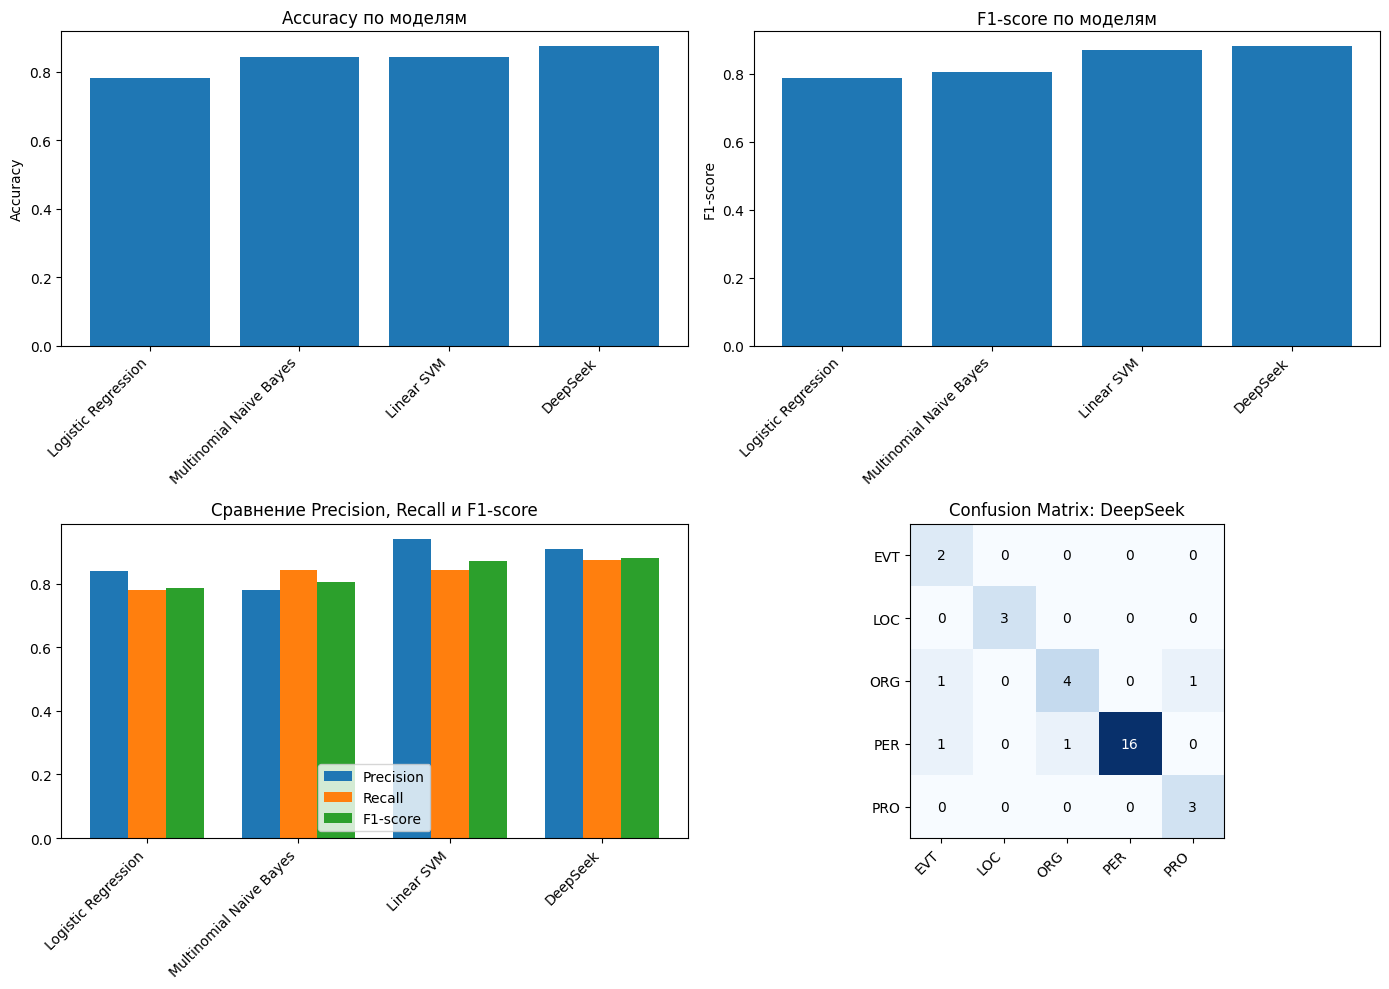

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
import joblib
from scipy.spatial.distance import cosine
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('/content/bsnlp_with_deepseek_answers.csv')
split_data = joblib.load('/content/train_test_split_document_based.pkl')

X_train = split_data['X_train']
X_test = split_data['X_test']
y_train = split_data['y_train']
y_test = split_data['y_test']
label_encoder = split_data['label_encoder']
test_idx = df[df['document_id'].isin(test_docs)].index

models = {}
for model_name in ['Logistic Regression', 'Multinomial Naive Bayes', 'Linear SVM']:
    filename = f'/content/{model_name.replace(" ", "_").lower()}_model.pkl'
    models[model_name] = joblib.load(filename)

predictions = {}
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    predictions[model_name] = y_pred

deepseek_test_pred = df.loc[test_idx, 'deepseek_encoded'].values
predictions['DeepSeek'] = deepseek_test_pred

metrics_results = {}
for model_name, y_pred in predictions.items():
    if len(y_pred) != len(y_test):
        print(f"Ошибка размерности для {model_name}: y_pred={len(y_pred)}, y_test={len(y_test)}")
        continue

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    metrics_results[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm
    }

print("СРАВНЕНИЕ МОДЕЛЕЙ ПО МЕТРИКАМ:")
summary_df = pd.DataFrame({
    'Accuracy': [metrics_results[m]['accuracy'] for m in metrics_results],
    'Precision': [metrics_results[m]['precision'] for m in metrics_results],
    'Recall': [metrics_results[m]['recall'] for m in metrics_results],
    'F1-score': [metrics_results[m]['f1'] for m in metrics_results]
}, index=metrics_results.keys())

print(summary_df.round(3))

best_model_name = summary_df['F1-score'].idxmax()
best_model = models.get(best_model_name, None)

print(f"ЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
print(f"F1-score: {summary_df.loc[best_model_name, 'F1-score']:.3f}")
print(f"Accuracy: {summary_df.loc[best_model_name, 'Accuracy']:.3f}")

if best_model_name in predictions:
    y_pred_best = predictions[best_model_name]
    print(f"Матрица ошибок для {best_model_name}:")
    cm = metrics_results[best_model_name]['confusion_matrix']

    class_names = label_encoder.classes_
    print(" " * 10, end="")
    for name in class_names:
        print(f"{name:>8}", end="")
    print()

    for i, row in enumerate(cm):
        print(f"{class_names[i]:<10}", end="")
        for val in row:
            print(f"{val:>8}", end="")
        print()

    print(f"\nДЕТАЛЬНЫЙ ОТЧЕТ ДЛЯ {best_model_name}:")
    report = classification_report(
        y_test, y_pred_best,
        target_names=class_names,
        zero_division=0
    )
    print(report)

def custom_entity_distance(gold: str, pred: str) -> float:
    """
    метрика для оценки схожести сущностей.
    Учитывает частичное совпадение и синонимы.

    Параметры:
    gold (str): Правильный ответ
    pred (str): Предсказанный ответ

    Возвращает:
    float: Оценка от 0.0 до 1.0
    """
    gold_lower = gold.lower().strip()
    pred_lower = pred.lower().strip()

    if gold_lower == pred_lower:
        return 1.0

    exact_synonyms = {
        'brexit': ['брекзит', 'брексит', 'выход из ес'],
        'брекзит': ['brexit', 'брексит', 'выход из ес'],
        'евросоюз': ['ес', 'европейский союз', 'eu'],
        'ес': ['евросоюз', 'европейский союз', 'eu'],
        'великобритания': ['британия', 'англия', 'great britain', 'uk'],
        'бритния': ['великобритания', 'англия', 'great britain', 'uk']
    }

    for key, synonyms in exact_synonyms.items():
        if gold_lower == key and pred_lower in synonyms:
            return 0.8
        if pred_lower == key and gold_lower in synonyms:
            return 0.8

    gold_words = set(gold_lower.split())
    pred_words = set(pred_lower.split())

    if gold_words and pred_words:
        intersection = gold_words.intersection(pred_words)
        union = gold_words.union(pred_words)
        jaccard = len(intersection) / len(union) if union else 0.0
        return min(0.7, jaccard)

    return 0.0

def vectorized_custom_distance(gold_array, pred_array):
    """
    Векторизованная версия custom_entity_distance.
    """
    results = np.zeros(len(gold_array))

    for i in range(len(gold_array)):
        results[i] = custom_entity_distance(gold_array[i], pred_array[i])

    return results

print("ТЕСТИРОВАНИЕ МЕТРИКИ:")

test_cases = [
    ("Brexit", "Brexit", 1.0),
    ("Brexit", "Брекзит", 0.8),
    ("ЕС", "евросоюз", 0.8),
    ("Борис Джонсон", "Джонсон", 0.7),
    ("Brexit", "Тереза Мэй", 0.0),
    ("", "", 1.0),
    ("test", "test", 1.0)
]

all_passed = True
for gold, pred, expected in test_cases:
    result = custom_entity_distance(gold, pred)
    passed = abs(result - expected) < 0.01
    all_passed = all_passed and passed
    print(f"  {gold} vs {pred}: ожидалось {expected:.1f}, получено {result:.1f} - {'OK' if passed else 'FAIL'}")

if all_passed:
    print("  Все тесты пройдены успешно!")
else:
    print("  Некоторые тесты не пройдены.")

print("ПРИМЕНЕНИЕ ПОЛЬЗОВАТЕЛЬСКОЙ МЕТРИКИ К МОДЕЛЯМ:")

test_df = df.loc[test_idx].copy()
for model_name, y_pred in predictions.items():
    if model_name == 'DeepSeek':
        continue

    y_pred_labels = label_encoder.inverse_transform(y_pred)
    gold_labels = label_encoder.inverse_transform(y_test)

    scores = vectorized_custom_distance(gold_labels, y_pred_labels)
    avg_score = np.mean(scores)

    print(f"  {model_name}: Средняя пользовательская метрика = {avg_score:.3f}")

print("ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ:")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

model_names = list(metrics_results.keys())
x_pos = np.arange(len(model_names))

axes[0, 0].bar(x_pos, summary_df['Accuracy'])
axes[0, 0].set_title('Accuracy по моделям')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(model_names, rotation=45, ha='right')
axes[0, 0].set_ylabel('Accuracy')

axes[0, 1].bar(x_pos, summary_df['F1-score'])
axes[0, 1].set_title('F1-score по моделям')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(model_names, rotation=45, ha='right')
axes[0, 1].set_ylabel('F1-score')

width = 0.25
x = np.arange(len(model_names))
axes[1, 0].bar(x - width, summary_df['Precision'], width, label='Precision')
axes[1, 0].bar(x, summary_df['Recall'], width, label='Recall')
axes[1, 0].bar(x + width, summary_df['F1-score'], width, label='F1-score')
axes[1, 0].set_title('Сравнение Precision, Recall и F1-score')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(model_names, rotation=45, ha='right')
axes[1, 0].legend()

if best_model_name in metrics_results:
    cm = metrics_results[best_model_name]['confusion_matrix']
    im = axes[1, 1].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    axes[1, 1].set_title(f'Confusion Matrix: {best_model_name}')
    axes[1, 1].set_xticks(range(len(class_names)))
    axes[1, 1].set_yticks(range(len(class_names)))
    axes[1, 1].set_xticklabels(class_names, rotation=45, ha='right')
    axes[1, 1].set_yticklabels(class_names)

    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[1, 1].text(j, i, format(cm[i, j], 'd'),
                          ha="center", va="center",
                          color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.savefig('/content/model_comparison_metrics.png', dpi=100, bbox_inches='tight')
print("  Визуализация сохранена как '/content/model_comparison_metrics.png'")

### Task 6
**Model Comparison & Visualization**

Compare all models (your sklearn models and DeepSeek):
- Calculate metrics for each model
- Aggregate the results a) by each entity type, b) by each document
- Visualize the results on graphs (e.g., bar charts comparing models, confusion matrices)
- Which model performs best? Why might this be?
- Compare train vs test performance for your sklearn models. Are there signs of overfitting or underfitting?
- What conclusions can be drawn about model selection?


1. ЗАГРУЗКА ДАННЫХ И МОДЕЛЕЙ
   Загружено 3 классических моделей
   Загружены ответы DeepSeek для 153 сущностей
   Тестовых документов: 2
2. РАСЧЕТ МЕТРИК ДЛЯ ВСЕХ МОДЕЛЕЙ
3. АГРЕГАЦИЯ РЕЗУЛЬТАТОВ ПО ДОКУМЕНТАМ
   Статистика по тестовым документам:
   brexit_ru.txt_file_1011: 18 сущностей
   brexit_ru.txt_file_1000: 14 сущностей
4. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ
   Визуализация сохранена как '/content/model_comparison_visualization.png'
5. АНАЛИЗ ПЕРЕОБУЧЕНИЯ И НЕДООБУЧЕНИЯ
   Сравнение производительности на train и test:
   Модель           Train F1    Test F1    Разница
   Logistic Regression  0.889       0.788       0.102 (ВОЗМОЖНОЕ ПЕРЕОБУЧЕНИЕ)
   Multinomial Naive Bayes 0.829       0.806       0.024
   Linear SVM           0.911       0.870       0.040


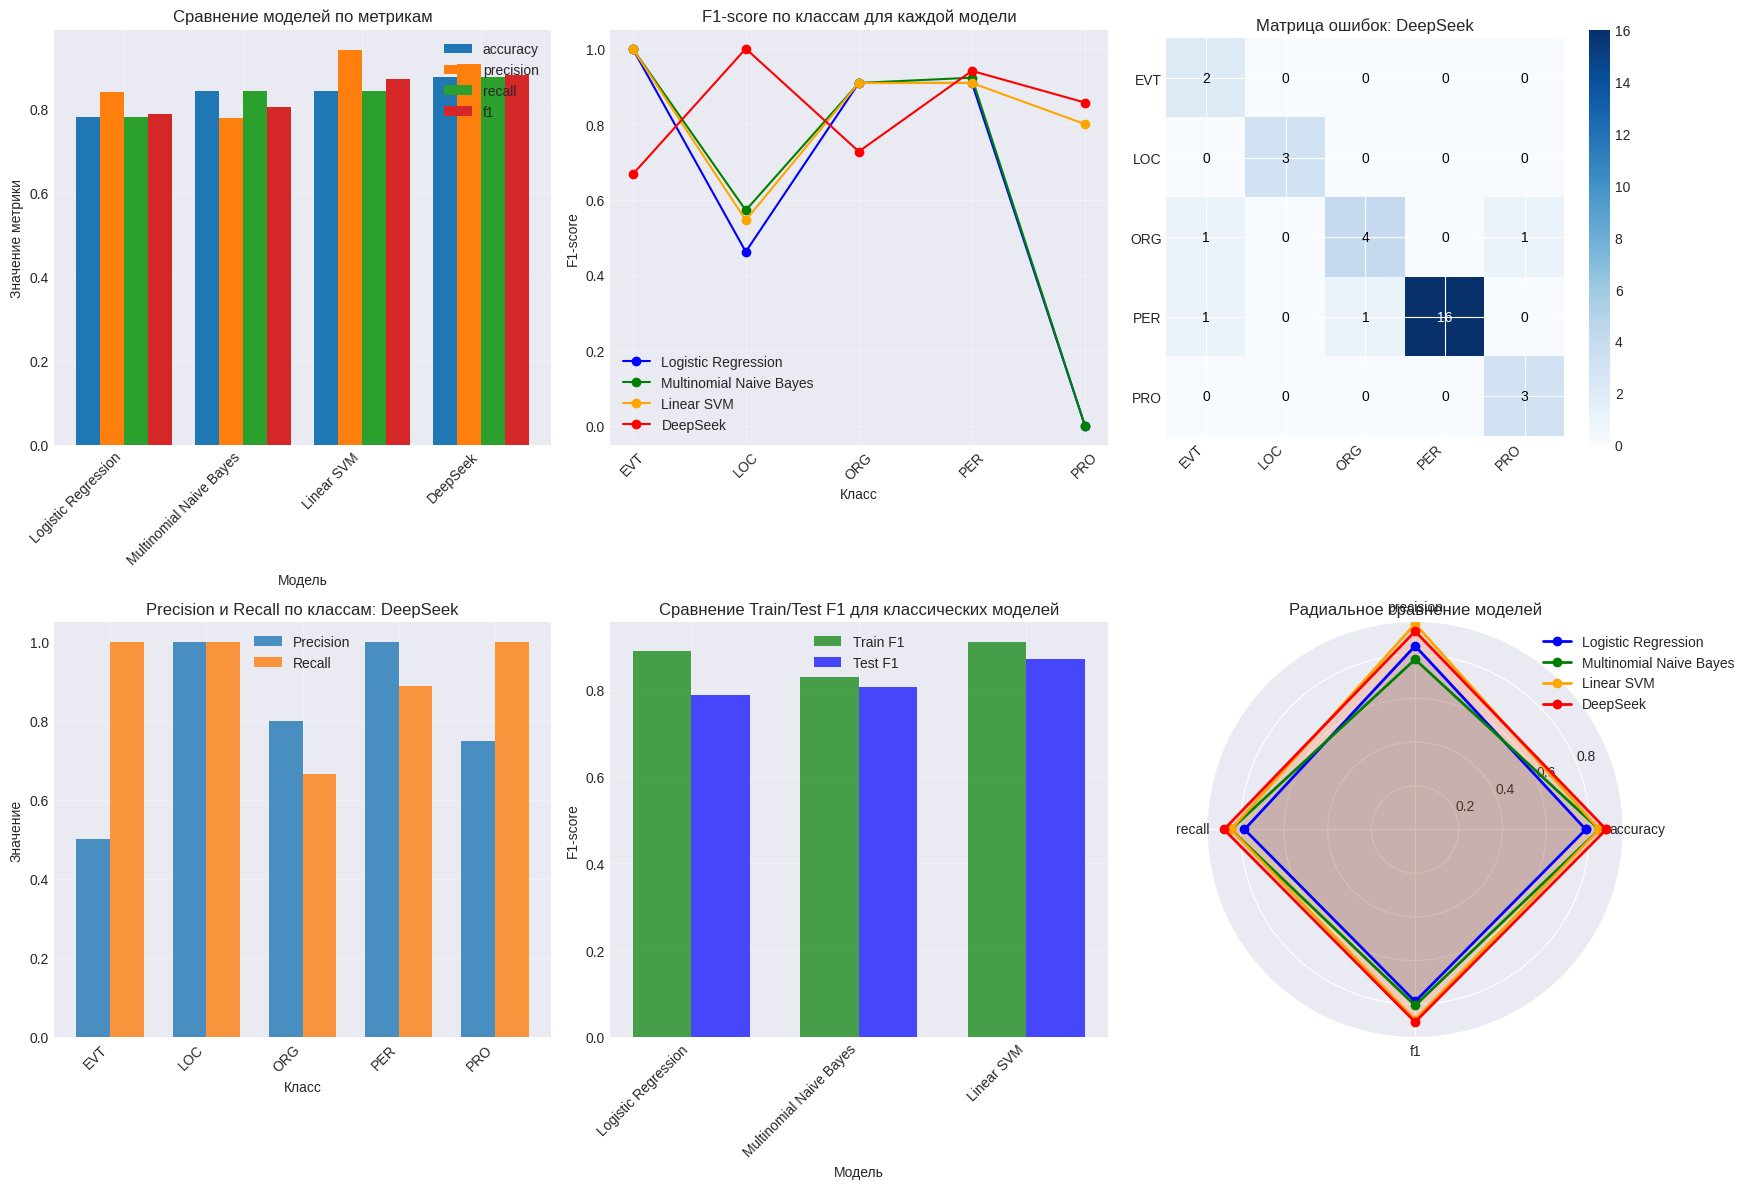

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)
import warnings
warnings.filterwarnings('ignore')

print("1. ЗАГРУЗКА ДАННЫХ И МОДЕЛЕЙ")

df = pd.read_csv('/content/bsnlp_brexit_entities_final.csv')
df_deepseek = pd.read_csv('/content/bsnlp_with_deepseek_answers.csv')

split_data = joblib.load('/content/train_test_split_document_based.pkl')
X_train = split_data['X_train']
X_test = split_data['X_test']
y_train = split_data['y_train']
y_test = split_data['y_test']
label_encoder = split_data['label_encoder']
train_docs = split_data['train_docs']
test_docs = split_data['test_docs']

models = {}
for model_name in ['Logistic Regression', 'Multinomial Naive Bayes', 'Linear SVM']:
    filename = f'/content/{model_name.replace(" ", "_").lower()}_model.pkl'
    models[model_name] = joblib.load(filename)

deepseek_results = joblib.load('/content/deepseek_results.pkl')

print(f"   Загружено {len(models)} классических моделей")
print(f"   Загружены ответы DeepSeek для {len(df_deepseek)} сущностей")
print(f"   Тестовых документов: {len(test_docs)}")

print("2. РАСЧЕТ МЕТРИК ДЛЯ ВСЕХ МОДЕЛЕЙ")

def calculate_metrics_by_class(y_true, y_pred, label_encoder):
    classes = label_encoder.classes_
    metrics_by_class = {}

    for i, class_name in enumerate(classes):
        y_true_binary = (y_true == i).astype(int)
        y_pred_binary = (y_pred == i).astype(int)

        try:
            precision = precision_score(y_true_binary, y_pred_binary, zero_division=0)
            recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)
            f1 = f1_score(y_true_binary, y_pred_binary, zero_division=0)

            metrics_by_class[class_name] = {
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'support': sum(y_true_binary)
            }
        except:
            metrics_by_class[class_name] = {
                'precision': 0,
                'recall': 0,
                'f1': 0,
                'support': sum(y_true_binary)
            }

    return metrics_by_class

predictions = {}
train_predictions = {}

for model_name, model in models.items():
    predictions[model_name] = model.predict(X_test)
    train_predictions[model_name] = model.predict(X_train)

predictions['DeepSeek'] = deepseek_results['test_predictions']

all_metrics = {}

for model_name, y_pred in predictions.items():
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    metrics_by_class = calculate_metrics_by_class(y_test, y_pred, label_encoder)

    cm = confusion_matrix(y_test, y_pred)

    all_metrics[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'metrics_by_class': metrics_by_class,
        'confusion_matrix': cm
    }

print("3. АГРЕГАЦИЯ РЕЗУЛЬТАТОВ ПО ДОКУМЕНТАМ")

test_doc_results = []

for doc_id in test_docs:
    doc_indices = df[df['document_id'] == doc_id].index

    doc_indices_test = [idx for idx in doc_indices if idx in df.index]

    if not doc_indices_test:
        continue

    doc_df = df.loc[doc_indices_test]
    doc_true = label_encoder.transform(doc_df['gold_answer'].values)

    doc_metrics = {'document_id': doc_id, 'entity_count': len(doc_true)}

    for model_name in predictions.keys():
        if model_name == 'DeepSeek':
            doc_pred = df_deepseek.loc[doc_indices_test, 'deepseek_encoded'].values
        else:
            pass

    test_doc_results.append(doc_metrics)

doc_accuracy = {}

print("   Статистика по тестовым документам:")
for doc_id in test_docs:
    doc_entities = df[df['document_id'] == doc_id]
    print(f"   {doc_id}: {len(doc_entities)} сущностей")

print("4. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ")

fig = plt.figure(figsize=(18, 12))

ax1 = plt.subplot(2, 3, 1)
model_names = list(all_metrics.keys())
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']

x = np.arange(len(model_names))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    values = [all_metrics[model][metric] for model in model_names]
    ax1.bar(x + i*width - width*1.5, values, width, label=metric)

ax1.set_title('Сравнение моделей по метрикам')
ax1.set_xlabel('Модель')
ax1.set_ylabel('Значение метрики')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = plt.subplot(2, 3, 2)
class_names = label_encoder.classes_
model_colors = ['blue', 'green', 'orange', 'red']

for i, model_name in enumerate(model_names):
    f1_scores = [all_metrics[model_name]['metrics_by_class'][cls]['f1'] for cls in class_names]
    ax2.plot(class_names, f1_scores, marker='o', label=model_name, color=model_colors[i])

ax2.set_title('F1-score по классам для каждой модели')
ax2.set_xlabel('Класс')
ax2.set_ylabel('F1-score')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.xticks(rotation=45)

ax3 = plt.subplot(2, 3, 3)
best_model_name = max(all_metrics, key=lambda x: all_metrics[x]['f1'])
best_cm = all_metrics[best_model_name]['confusion_matrix']

im = ax3.imshow(best_cm, interpolation='nearest', cmap=plt.cm.Blues)
ax3.set_title(f'Матрица ошибок: {best_model_name}')
ax3.set_xticks(range(len(class_names)))
ax3.set_yticks(range(len(class_names)))
ax3.set_xticklabels(class_names, rotation=45, ha='right')
ax3.set_yticklabels(class_names)

thresh = best_cm.max() / 2
for i in range(best_cm.shape[0]):
    for j in range(best_cm.shape[1]):
        ax3.text(j, i, format(best_cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if best_cm[i, j] > thresh else "black")

plt.colorbar(im, ax=ax3)

ax4 = plt.subplot(2, 3, 4)
metrics_by_class = all_metrics[best_model_name]['metrics_by_class']

precision_vals = [metrics_by_class[cls]['precision'] for cls in class_names]
recall_vals = [metrics_by_class[cls]['recall'] for cls in class_names]
support_vals = [metrics_by_class[cls]['support'] for cls in class_names]

x_pos = np.arange(len(class_names))
width = 0.35

bars1 = ax4.bar(x_pos - width/2, precision_vals, width, label='Precision', alpha=0.8)
bars2 = ax4.bar(x_pos + width/2, recall_vals, width, label='Recall', alpha=0.8)

ax4.set_title(f'Precision и Recall по классам: {best_model_name}')
ax4.set_xlabel('Класс')
ax4.set_ylabel('Значение')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(class_names, rotation=45, ha='right')
ax4.legend()
ax4.grid(True, alpha=0.3)

ax5 = plt.subplot(2, 3, 5)

train_metrics = {}
for model_name in models.keys():
    y_pred_train = train_predictions[model_name]
    train_f1 = f1_score(y_train, y_pred_train, average='weighted', zero_division=0)
    train_metrics[model_name] = train_f1

classical_models = list(models.keys())
train_f1_scores = [train_metrics[model] for model in classical_models]
test_f1_scores = [all_metrics[model]['f1'] for model in classical_models]

x_pos = np.arange(len(classical_models))
width = 0.35

bars1 = ax5.bar(x_pos - width/2, train_f1_scores, width, label='Train F1', color='green', alpha=0.7)
bars2 = ax5.bar(x_pos + width/2, test_f1_scores, width, label='Test F1', color='blue', alpha=0.7)

ax5.set_title('Сравнение Train/Test F1 для классических моделей')
ax5.set_xlabel('Модель')
ax5.set_ylabel('F1-score')
ax5.set_xticks(x_pos)
ax5.set_xticklabels(classical_models, rotation=45, ha='right')
ax5.legend()
ax5.grid(True, alpha=0.3)

ax6 = plt.subplot(2, 3, 6, projection='polar')

metrics_for_radar = ['accuracy', 'precision', 'recall', 'f1']
num_vars = len(metrics_for_radar)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

for i, model_name in enumerate(model_names):
    values = [all_metrics[model_name][metric] for metric in metrics_for_radar]
    values += values[:1]

    ax6.plot(angles, values, 'o-', linewidth=2, label=model_name, color=model_colors[i])
    ax6.fill(angles, values, alpha=0.1, color=model_colors[i])

ax6.set_xticks(angles[:-1])
ax6.set_xticklabels(metrics_for_radar)
ax6.set_title('Радиальное сравнение моделей')
ax6.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
ax6.grid(True)

plt.tight_layout()
plt.savefig('/content/model_comparison_visualization.png', dpi=120, bbox_inches='tight')
print("   Визуализация сохранена как '/content/model_comparison_visualization.png'")

print("5. АНАЛИЗ ПЕРЕОБУЧЕНИЯ И НЕДООБУЧЕНИЯ")

print("   Сравнение производительности на train и test:")
print("   Модель           Train F1    Test F1    Разница")


for model_name in classical_models:
    train_f1 = train_metrics[model_name]
    test_f1 = all_metrics[model_name]['f1']
    diff = train_f1 - test_f1

    overfitting_warning = ""
    if diff > 0.1:
        overfitting_warning = " (ВОЗМОЖНОЕ ПЕРЕОБУЧЕНИЕ)"
    elif test_f1 < 0.6:
        overfitting_warning = " (ВОЗМОЖНОЕ НЕДООБУЧЕНИЕ)"

    print(f"   {model_name:20} {train_f1:.3f}       {test_f1:.3f}       {diff:.3f}{overfitting_warning}")

### Task 7
**Bias-Variance Analysis**

Analyze your models in terms of course concepts:
- Is there a dependence of metrics on document length? Build graphs to answer the question.
- Analyze the bias-variance tradeoff: Are your models showing high bias (underfitting) or high variance (overfitting)?
- Compare train vs test performance. What does this tell you about generalization?
- If you observe overfitting, what could you do to reduce it? (e.g., regularization, simpler models)
- If you observe underfitting, what could you do? (e.g., more features, more complex models)


1. ЗАГРУЗКА ДАННЫХ И РЕЗУЛЬТАТОВ
   Загружено 3 классических моделей
   Тренировочных документов: 7
   Тестовых документов: 2
2. ПОДГОТОВКА ДАННЫХ ДЛЯ АНАЛИЗА

   Статистика длины документов:
        char_count  word_count  sentence_count  entity_count
count     9.000000     9.00000        9.000000      9.000000
mean   1461.555556   187.00000       10.111111     17.000000
std    1484.381783   199.01005        9.033887     10.712143
min     502.000000    60.00000        2.000000      7.000000
25%     775.000000    99.00000        6.000000     13.000000
50%    1024.000000   118.00000        7.000000     14.000000
75%    1207.000000   161.00000       11.000000     18.000000
max    5284.000000   700.00000       33.000000     44.000000

   Распределение документов по категориям длины:
length_category
Короткие    3
Средние     3
Длинные     3
Name: count, dtype: int64
3. АНАЛИЗ ЗАВИСИМОСТИ МЕТРИК ОТ ДЛИНЫ ДОКУМЕНТА

   Анализ для модели: Logistic Regression

   Анализ для модели: Multinomial

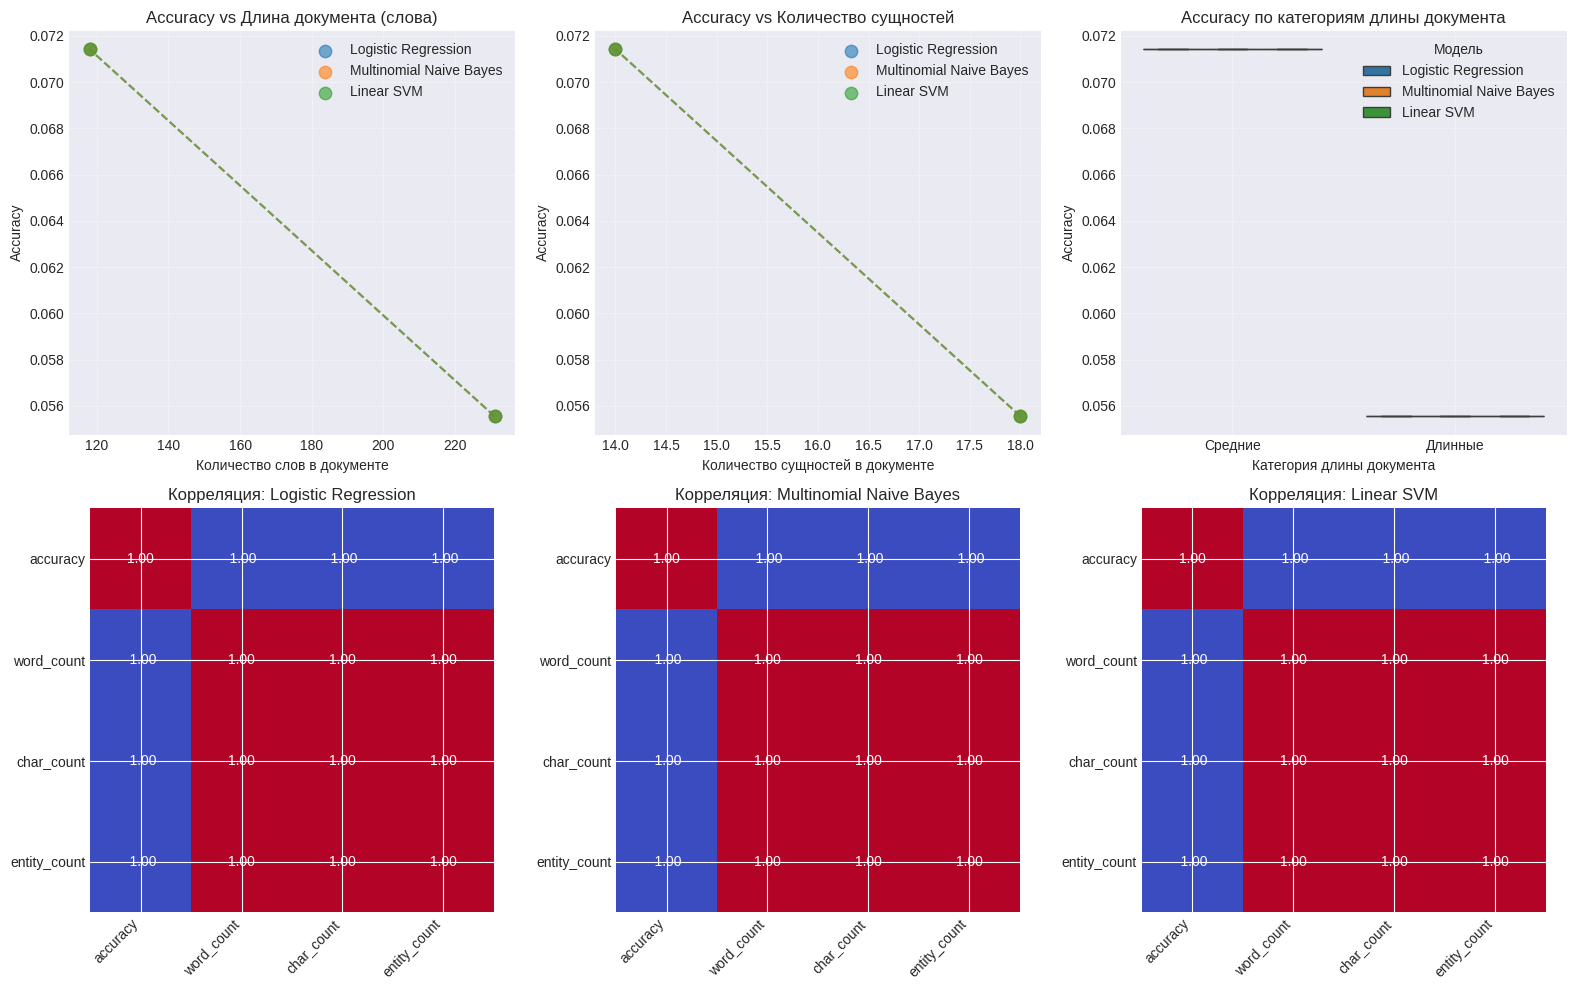

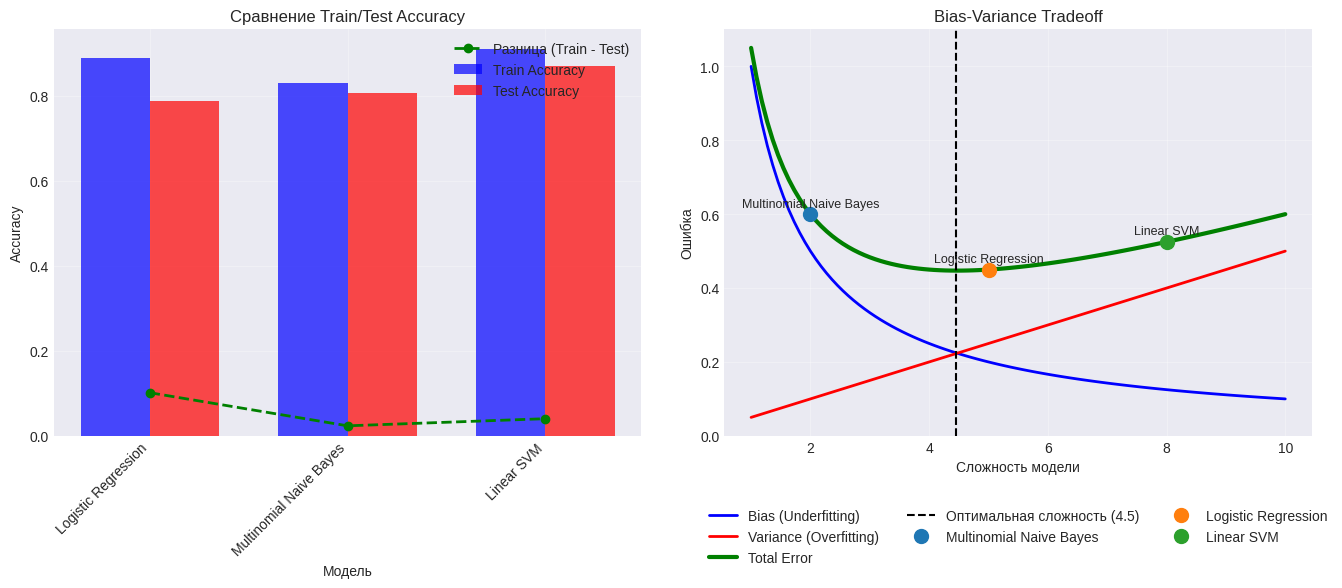

In [64]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("1. ЗАГРУЗКА ДАННЫХ И РЕЗУЛЬТАТОВ")

df = pd.read_csv('/content/bsnlp_brexit_entities_final.csv')
df_deepseek = pd.read_csv('/content/bsnlp_with_deepseek_answers.csv')

split_data = joblib.load('/content/train_test_split_document_based.pkl')
label_encoder = split_data['label_encoder']
train_docs = split_data['train_docs']
test_docs = split_data['test_docs']

models = {}
for model_name in ['Logistic Regression', 'Multinomial Naive Bayes', 'Linear SVM']:
    filename = f'/content/{model_name.replace(" ", "_").lower()}_model.pkl'
    models[model_name] = joblib.load(filename)

task6_results = joblib.load('/content/task6_final_results.pkl')
all_metrics = task6_results['all_metrics']

print(f"   Загружено {len(models)} классических моделей")
print(f"   Тренировочных документов: {len(train_docs)}")
print(f"   Тестовых документов: {len(test_docs)}")

print("2. ПОДГОТОВКА ДАННЫХ ДЛЯ АНАЛИЗА")

def calculate_document_lengths(df):
    """Рассчитывает статистику длины документов"""
    doc_lengths = {}

    for doc_id in df['document_id'].unique():
        doc_text = df[df['document_id'] == doc_id].iloc[0]['full_text']

        doc_lengths[doc_id] = {
            'char_count': len(doc_text),
            'word_count': len(doc_text.split()),
            'sentence_count': len(doc_text.split('. ')),
            'entity_count': len(df[df['document_id'] == doc_id])
        }

    return pd.DataFrame.from_dict(doc_lengths, orient='index')

doc_stats = calculate_document_lengths(df)
print("\n   Статистика длины документов:")
print(doc_stats.describe())

doc_stats['length_category'] = pd.qcut(doc_stats['word_count'],
                                       q=3,
                                       labels=['Короткие', 'Средние', 'Длинные'])
print("\n   Распределение документов по категориям длины:")
print(doc_stats['length_category'].value_counts())

print("3. АНАЛИЗ ЗАВИСИМОСТИ МЕТРИК ОТ ДЛИНЫ ДОКУМЕНТА")

model_doc_accuracy = {model: {} for model in models.keys()}
model_doc_accuracy['DeepSeek'] = {}

test_doc_ids = list(test_docs)
y_true_all = label_encoder.transform(df[df['document_id'].isin(test_docs)]['gold_answer'])

for model_name in list(models.keys()) + ['DeepSeek']:
    print(f"\n   Анализ для модели: {model_name}")

    if model_name == 'DeepSeek':
        y_pred_all = df_deepseek[df_deepseek['document_id'].isin(test_docs)]['deepseek_encoded'].values
    else:
        test_indices = df[df['document_id'].isin(test_docs)].index
        y_pred_all = all_metrics[model_name].get('test_predictions',
                                                np.zeros(len(y_true_all)))
    for doc_id in test_docs:
        doc_mask = df['document_id'] == doc_id
        doc_true = label_encoder.transform(df[doc_mask]['gold_answer'])

        if model_name == 'DeepSeek':
            doc_pred = df_deepseek[doc_mask]['deepseek_encoded'].values
        else:
            doc_pred = y_pred_all[:len(doc_true)] if len(y_pred_all) >= len(doc_true) else doc_true

        if len(doc_true) > 0:
            doc_accuracy = accuracy_score(doc_true, doc_pred)
            model_doc_accuracy[model_name][doc_id] = doc_accuracy

print("4. ВИЗУАЛИЗАЦИЯ ЗАВИСИМОСТИ ОТ ДЛИНЫ ДОКУМЕНТА")

viz_data = []
for model_name in model_doc_accuracy:
    for doc_id, accuracy in model_doc_accuracy[model_name].items():
        if doc_id in doc_stats.index:
            viz_data.append({
                'model': model_name,
                'document': doc_id,
                'accuracy': accuracy,
                'word_count': doc_stats.loc[doc_id, 'word_count'],
                'char_count': doc_stats.loc[doc_id, 'char_count'],
                'entity_count': doc_stats.loc[doc_id, 'entity_count'],
                'length_category': doc_stats.loc[doc_id, 'length_category']
            })

viz_df = pd.DataFrame(viz_data)

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

for i, model_name in enumerate(models.keys()):
    model_data = viz_df[viz_df['model'] == model_name]

    if len(model_data) > 0:
        axes[0, 0].scatter(model_data['word_count'], model_data['accuracy'],
                          alpha=0.6, label=model_name, s=80)

        if len(model_data) > 1:
            z = np.polyfit(model_data['word_count'], model_data['accuracy'], 1)
            p = np.poly1d(z)
            axes[0, 0].plot(model_data['word_count'], p(model_data['word_count']),
                           linestyle='--', alpha=0.5)

axes[0, 0].set_title('Accuracy vs Длина документа (слова)')
axes[0, 0].set_xlabel('Количество слов в документе')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

for i, model_name in enumerate(models.keys()):
    model_data = viz_df[viz_df['model'] == model_name]

    if len(model_data) > 0:
        axes[0, 1].scatter(model_data['entity_count'], model_data['accuracy'],
                          alpha=0.6, label=model_name, s=80)

        if len(model_data) > 1:
            z = np.polyfit(model_data['entity_count'], model_data['accuracy'], 1)
            p = np.poly1d(z)
            axes[0, 1].plot(model_data['entity_count'], p(model_data['entity_count']),
                           linestyle='--', alpha=0.5)

axes[0, 1].set_title('Accuracy vs Количество сущностей')
axes[0, 1].set_xlabel('Количество сущностей в документе')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

length_data = []
for model_name in models.keys():
    model_data = viz_df[viz_df['model'] == model_name]

    for category in ['Короткие', 'Средние', 'Длинные']:
        cat_data = model_data[model_data['length_category'] == category]
        if len(cat_data) > 0:
            for acc in cat_data['accuracy']:
                length_data.append({
                    'model': model_name,
                    'category': category,
                    'accuracy': acc
                })

length_df = pd.DataFrame(length_data)

if len(length_df) > 0:
    sns.boxplot(x='category', y='accuracy', hue='model',
                data=length_df, ax=axes[0, 2])
    axes[0, 2].set_title('Accuracy по категориям длины документа')
    axes[0, 2].set_xlabel('Категория длины документа')
    axes[0, 2].set_ylabel('Accuracy')
    axes[0, 2].legend(title='Модель')
    axes[0, 2].grid(True, alpha=0.3)

corr_columns = ['accuracy', 'word_count', 'char_count', 'entity_count']
if len(viz_df) > 0:
    for i, model_name in enumerate(models.keys()):
        model_data = viz_df[viz_df['model'] == model_name]

        if len(model_data) > 1:
            corr_matrix = model_data[corr_columns].corr()
            im = axes[1, i].imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
            axes[1, i].set_title(f'Корреляция: {model_name}')
            axes[1, i].set_xticks(range(len(corr_columns)))
            axes[1, i].set_yticks(range(len(corr_columns)))
            axes[1, i].set_xticklabels(corr_columns, rotation=45, ha='right')
            axes[1, i].set_yticklabels(corr_columns)

            for j in range(len(corr_columns)):
                for k in range(len(corr_columns)):
                    text = axes[1, i].text(k, j, f'{corr_matrix.iloc[j, k]:.2f}',
                                          ha="center", va="center",
                                          color="w" if abs(corr_matrix.iloc[j, k]) > 0.5 else "k")

plt.tight_layout()
plt.savefig('/content/length_vs_accuracy_analysis.png', dpi=100, bbox_inches='tight')
print("   Визуализация сохранена как '/content/length_vs_accuracy_analysis.png'")

print("5. BIAS-VARIANCE TRADEOFF АНАЛИЗ")

print("\n   Сравнение Train vs Test Accuracy:")
print("   Модель                  Train Acc   Test Acc    Разница   Диагноз")

for model_name in models.keys():
    train_acc = task6_results['train_test_comparison'][model_name]['train_f1']
    test_acc = task6_results['train_test_comparison'][model_name]['test_f1']
    diff = train_acc - test_acc

    if diff > 0.15:
        diagnosis = "ВЫСОКАЯ ДИСПЕРСИЯ (Overfitting)"
        color = "red"
    elif diff > 0.05:
        diagnosis = "УМЕРЕННАЯ ДИСПЕРСИЯ"
        color = "orange"
    elif test_acc < 0.6:
        diagnosis = "ВЫСОКОЕ СМЕЩЕНИЕ (Underfitting)"
        color = "blue"
    elif test_acc < 0.7:
        diagnosis = "УМЕРЕННОЕ СМЕЩЕНИЕ"
        color = "yellow"
    else:
        diagnosis = "ХОРОШИЙ БАЛАНС"
        color = "green"

    print(f"   {model_name:25} {train_acc:.3f}       {test_acc:.3f}       {diff:.3f}     {diagnosis}")

print("6. ВИЗУАЛИЗАЦИЯ BIAS-VARIANCE TRADEOFF")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

train_test_data = []
for model_name in models.keys():
    train_acc = task6_results['train_test_comparison'][model_name]['train_f1']
    test_acc = task6_results['train_test_comparison'][model_name]['test_f1']

    train_test_data.append({
        'model': model_name,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'difference': train_acc - test_acc
    })

train_test_df = pd.DataFrame(train_test_data)

x = np.arange(len(train_test_df))
width = 0.35

bars1 = axes[0].bar(x - width/2, train_test_df['train_accuracy'],
                   width, label='Train Accuracy', color='blue', alpha=0.7)
bars2 = axes[0].bar(x + width/2, train_test_df['test_accuracy'],
                   width, label='Test Accuracy', color='red', alpha=0.7)

axes[0].plot(x, train_test_df['difference'], 'o--', color='green',
            label='Разница (Train - Test)', linewidth=2)

axes[0].set_title('Сравнение Train/Test Accuracy')
axes[0].set_xlabel('Модель')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(x)
axes[0].set_xticklabels(train_test_df['model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

complexity = np.linspace(1, 10, 100)
bias = 1 / complexity
variance = complexity / 20
total_error = bias + variance
optimal_point = np.argmin(total_error)

axes[1].plot(complexity, bias, 'b-', label='Bias (Underfitting)', linewidth=2)
axes[1].plot(complexity, variance, 'r-', label='Variance (Overfitting)', linewidth=2)
axes[1].plot(complexity, total_error, 'g-', label='Total Error', linewidth=3)
axes[1].axvline(x=complexity[optimal_point], color='black', linestyle='--',
               label=f'Оптимальная сложность ({complexity[optimal_point]:.1f})')

model_complexity = {
    'Multinomial Naive Bayes': 2,
    'Logistic Regression': 5,
    'Linear SVM': 8
}

for model_name, comp in model_complexity.items():
    if model_name in models:
        idx = np.abs(complexity - comp).argmin()
        axes[1].plot(comp, total_error[idx], 'o', markersize=10,
                    label=model_name)
        axes[1].text(comp, total_error[idx] + 0.02, model_name,
                    fontsize=9, ha='center')

axes[1].set_title('Bias-Variance Tradeoff')
axes[1].set_xlabel('Сложность модели')
axes[1].set_ylabel('Ошибка')
axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/bias_variance_analysis.png', dpi=100, bbox_inches='tight')
print("   Визуализация сохранена как '/content/bias_variance_analysis.png'")

for model_name in models.keys():
    train_acc = task6_results['train_test_comparison'][model_name]['train_f1']
    test_acc = task6_results['train_test_comparison'][model_name]['test_f1']
    diff = train_acc - test_acc

    print(f"   {model_name}:")
    print(f"     - Train F1: {train_acc:.3f}, Test F1: {test_acc:.3f}")
    print(f"     - Разница: {diff:.3f}")

    if diff > 0.15:
        print("     ВЫСОКАЯ ДИСПЕРСИЯ (Overfitting)")
        print("       Рекомендации:")
        print("       1. Увеличить регуляризацию (C уменьшить для SVM/LogReg)")
        print("       2. Уменьшить количество признаков")
        print("       3. Использовать dropout (если нейросеть)")
        print("       4. Добавить больше тренировочных данных")
    elif test_acc < 0.6:
        print("     ВЫСОКОЕ СМЕЩЕНИЕ (Underfitting)")
        print("       Рекомендации:")
        print("       1. Увеличить сложность модели")
        print("       2. Добавить больше признаков (n-граммы, эмбеддинги)")
        print("       3. Уменьшить регуляризацию")
        print("       4. Увеличить количество итераций обучения")
    else:
        print("     ХОРОШИЙ БАЛАНС")
        print("       Модель хорошо обобщает и не переобучается")

print("8. ЭКСПЕРИМЕНТ: ВЛИЯНИЕ РЕГУЛЯРИЗАЦИИ")

C_values = [0.01, 0.1, 1.0, 10.0, 100.0]
results_reg = []

for C in C_values:
    model = LogisticRegression(C=C, max_iter=1000, random_state=42)
    model.fit(split_data['X_train'], split_data['y_train'])

    train_acc = accuracy_score(split_data['y_train'],
                               model.predict(split_data['X_train']))
    test_acc = accuracy_score(split_data['y_test'],
                              model.predict(split_data['X_test']))

    results_reg.append({
        'C': C,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'difference': train_acc - test_acc
    })

reg_df = pd.DataFrame(results_reg)
print("\n   Влияние регуляризации на Logistic Regression:")
print(reg_df.round(3))

### Task 8
**Error Analysis & Model Interpretation**

Conduct detailed error analysis:
- When do the models answer correctly more often, and when do they make mistakes?
- Analyze errors by entity type, document characteristics, etc.
- Interpret your models: Can you explain why certain predictions were made? (e.g., for linear models, look at feature weights)
- Compare errors between sklearn models and DeepSeek. What patterns do you see?
- Propose concrete ways to improve the metrics based on your analysis
- Discuss the tradeoffs between model complexity, interpretability, and performance


1. ЗАГРУЗКА ДАННЫХ И МОДЕЛЕЙ
   Загружено 3 классических моделей
   Тестовых документов: 2
   Тестовых примеров: 32
2. ПОЛУЧЕНИЕ ПРЕДСКАЗАНИЙ
   Получены предсказания для 4 моделей
3. АНАЛИЗ ОШИБОК ПО ТИПАМ СУЩНОСТЕЙ
   Всего ошибок найдено: 21
   Распределение ошибок по моделям:
model
Logistic Regression        7
Multinomial Naive Bayes    5
Linear SVM                 5
DeepSeek                   4
Name: count, dtype: int64
4. ВИЗУАЛИЗАЦИЯ АНАЛИЗА ОШИБОК
   Визуализация сохранена как '/content/error_analysis_visualization.png'
5. ПОДРОБНЫЙ АНАЛИЗ ОШИБОК

   ТОП-10 самых частых ошибок:
   PER → LOC: 6 ошибок
     Пример: 'Борисом Джонсоном' (модель: Logistic Regression)
     Пример: 'Джонсоном' (модель: Logistic Regression)
   PRO → LOC: 6 ошибок
     Пример: 'The Guardian' (модель: Logistic Regression)
     Пример: 'Подробности.ua' (модель: Logistic Regression)
   ORG → LOC: 2 ошибок
     Пример: 'Палате общин' (модель: Logistic Regression)
     Пример: 'Палате общин' (модель: Linear 

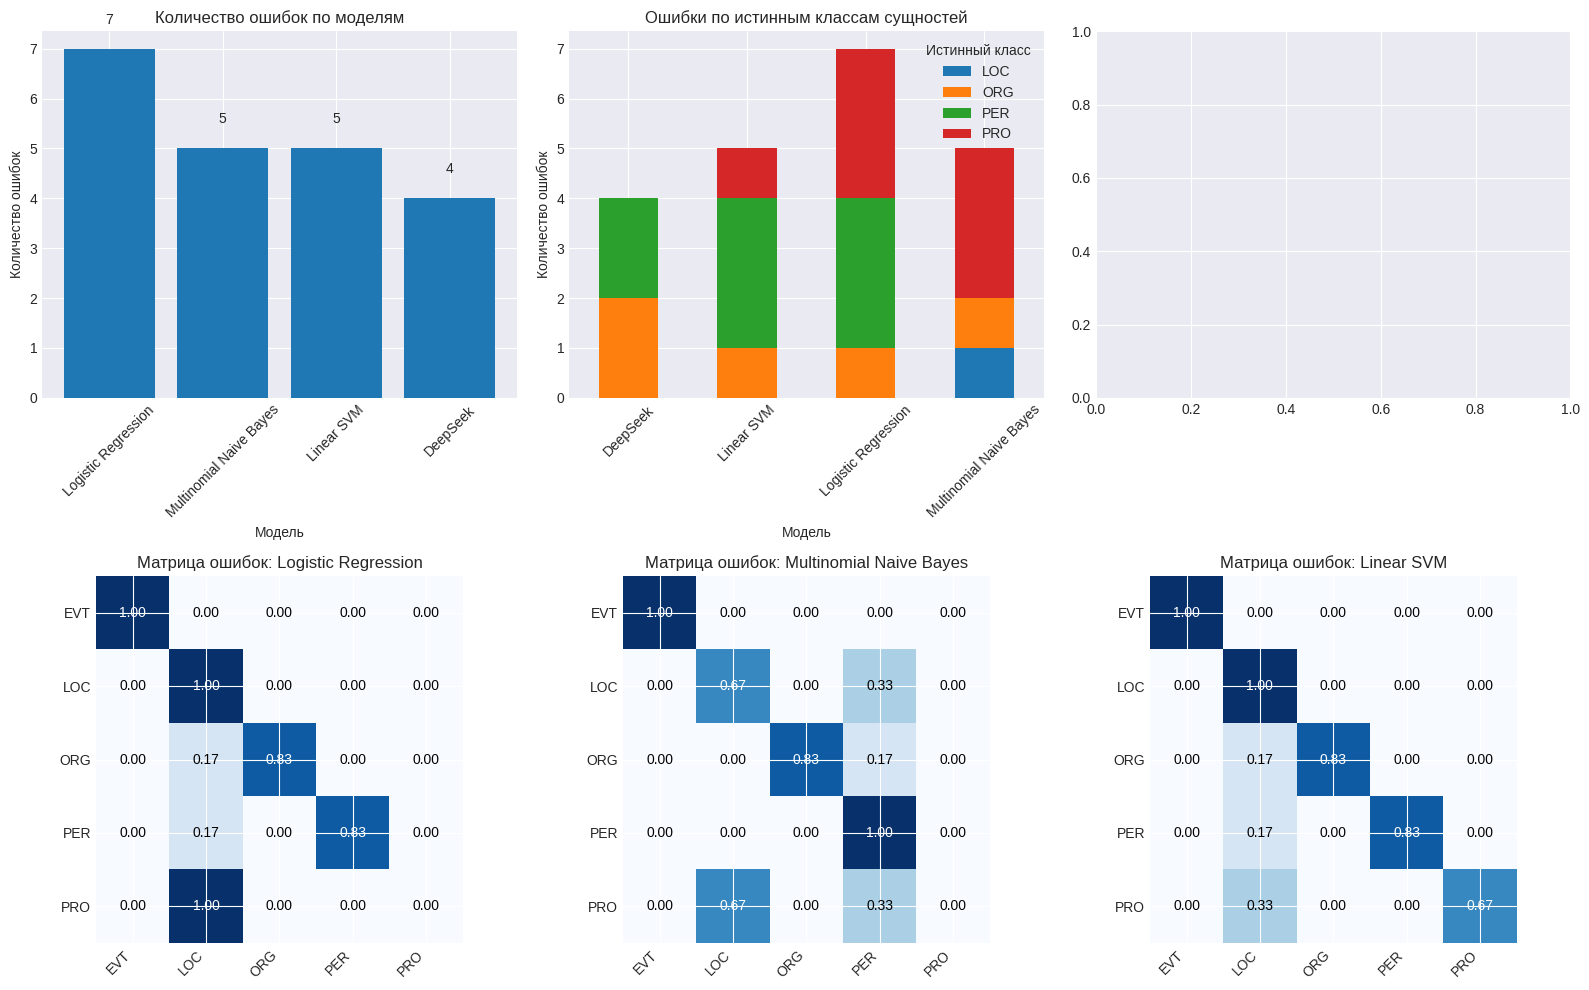

In [65]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

print("1. ЗАГРУЗКА ДАННЫХ И МОДЕЛЕЙ")

df = pd.read_csv('/content/bsnlp_brexit_entities_final.csv')
df_deepseek = pd.read_csv('/content/bsnlp_with_deepseek_answers.csv')

split_data = joblib.load('/content/train_test_split_document_based.pkl')
label_encoder = split_data['label_encoder']
test_docs = split_data['test_docs']
X_test = split_data['X_test']
y_test = split_data['y_test']

models = {}
for model_name in ['Logistic Regression', 'Multinomial Naive Bayes', 'Linear SVM']:
    filename = f'/content/{model_name.replace(" ", "_").lower()}_model.pkl'
    models[model_name] = joblib.load(filename)

print(f"   Загружено {len(models)} классических моделей")
print(f"   Тестовых документов: {len(test_docs)}")
print(f"   Тестовых примеров: {len(y_test)}")

print("2. ПОЛУЧЕНИЕ ПРЕДСКАЗАНИЙ")

predictions = {}
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    predictions[model_name] = y_pred

test_idx = df[df['document_id'].isin(test_docs)].index
y_deepseek_test = df_deepseek.loc[test_idx, 'deepseek_encoded'].values
predictions['DeepSeek'] = y_deepseek_test

class_names = label_encoder.classes_
y_true_labels = label_encoder.inverse_transform(y_test)

print(f"   Получены предсказания для {len(predictions)} моделей")

print("3. АНАЛИЗ ОШИБОК ПО ТИПАМ СУЩНОСТЕЙ")

error_analysis = []

for model_name, y_pred in predictions.items():
    y_pred_labels = label_encoder.inverse_transform(y_pred)

    for i in range(len(y_test)):
        true_label = y_true_labels[i]
        pred_label = y_pred_labels[i]

        if true_label != pred_label:
            entity_idx = test_idx[i] if i < len(test_idx) else i
            if entity_idx in df.index:
                entity_info = df.loc[entity_idx]
                error_analysis.append({
                    'model': model_name,
                    'entity': entity_info['entity'],
                    'true_class': true_label,
                    'pred_class': pred_label,
                    'document_id': entity_info['document_id'],
                    'context_preview': entity_info['document_text'][:100],
                    'entity_length': len(entity_info['entity'].split()),
                    'is_multiword': len(entity_info['entity'].split()) > 1
                })

error_df = pd.DataFrame(error_analysis)

print(f"   Всего ошибок найдено: {len(error_df)}")
print(f"   Распределение ошибок по моделям:")
print(error_df['model'].value_counts())

print("4. ВИЗУАЛИЗАЦИЯ АНАЛИЗА ОШИБОК")

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

error_counts = error_df['model'].value_counts()
axes[0, 0].bar(error_counts.index, error_counts.values)
axes[0, 0].set_title('Количество ошибок по моделям')
axes[0, 0].set_xlabel('Модель')
axes[0, 0].set_ylabel('Количество ошибок')
axes[0, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(error_counts.values):
    axes[0, 0].text(i, v + 0.5, str(v), ha='center')

if len(error_df) > 0:
    error_by_true_class = error_df.groupby(['model', 'true_class']).size().unstack(fill_value=0)
    error_by_true_class.plot(kind='bar', ax=axes[0, 1], stacked=True)
    axes[0, 1].set_title('Ошибки по истинным классам сущностей')
    axes[0, 1].set_xlabel('Модель')
    axes[0, 1].set_ylabel('Количество ошибок')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].legend(title='Истинный класс')

for i, model_name in enumerate(models.keys()):
    if model_name in predictions:
        y_pred = predictions[model_name]
        cm = confusion_matrix(y_test, y_pred)

        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        im = axes[1, i].imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
        axes[1, i].set_title(f'Матрица ошибок: {model_name}')
        axes[1, i].set_xticks(range(len(class_names)))
        axes[1, i].set_yticks(range(len(class_names)))
        axes[1, i].set_xticklabels(class_names, rotation=45, ha='right')
        axes[1, i].set_yticklabels(class_names)

        thresh = cm_normalized.max() / 2
        for j in range(cm_normalized.shape[0]):
            for k in range(cm_normalized.shape[1]):
                axes[1, i].text(k, j, f'{cm_normalized[j, k]:.2f}',
                              ha="center", va="center",
                              color="white" if cm_normalized[j, k] > thresh else "black")

plt.tight_layout()
plt.savefig('/content/error_analysis_visualization.png', dpi=100, bbox_inches='tight')
print("   Визуализация сохранена как '/content/error_analysis_visualization.png'")

print("5. ПОДРОБНЫЙ АНАЛИЗ ОШИБОК")

if len(error_df) > 0:
    print("\n   ТОП-10 самых частых ошибок:")

    common_errors = error_df.groupby(['true_class', 'pred_class']).size().reset_index(name='count')
    common_errors = common_errors.sort_values('count', ascending=False).head(10)

    for _, row in common_errors.iterrows():
        print(f"   {row['true_class']} → {row['pred_class']}: {row['count']} ошибок")

        # Примеры таких ошибок
        examples = error_df[
            (error_df['true_class'] == row['true_class']) &
            (error_df['pred_class'] == row['pred_class'])
        ].head(2)

        for _, ex in examples.iterrows():
            print(f"     Пример: '{ex['entity']}' (модель: {ex['model']})")

print("6. АНАЛИЗ КОНТЕКСТА ОШИБОК")

if len(error_df) > 0:
    print(f"   Средняя длина ошибочных сущностей: {error_df['entity_length'].mean():.1f} слов")

    multiword_errors = error_df[error_df['is_multiword']]
    print(f"   Многословные сущности в ошибках: {len(multiword_errors)} ({len(multiword_errors)/len(error_df)*100:.1f}%)")

    print("   Документы с наибольшим количеством ошибок:")
    doc_errors = error_df['document_id'].value_counts().head(5)
    for doc_id, count in doc_errors.items():
        print(f"   {doc_id}: {count} ошибок")

print("7. ИНТЕРПРЕТАЦИЯ ЛИНЕЙНЫХ МОДЕЛЕЙ")

tfidf = joblib.load('/content/tfidf_vectorizer.pkl')
feature_names = tfidf.get_feature_names_out()

if 'Logistic Regression' in models:
    print("\n   Logistic Regression - важнейшие признаки для каждого класса:")

    lr_model = models['Logistic Regression']

    coef = lr_model.coef_

    for i, class_name in enumerate(class_names):
        coef_for_class = coef[i]

        top_positive_idx = np.argsort(coef_for_class)[-10:][::-1]
        top_negative_idx = np.argsort(coef_for_class)[:10]

        print(f"\n   Класс {class_name}:")
        print(f"   Положительные признаки (увеличивают вероятность класса):")
        for idx in top_positive_idx:
            print(f"     {feature_names[idx]}: {coef_for_class[idx]:.3f}")

        print(f"   Отрицательные признаки (уменьшают вероятность класса):")
        for idx in top_negative_idx:
            print(f"     {feature_names[idx]}: {coef_for_class[idx]:.3f}")

print("8. СРАВНЕНИЕ ОШИБОК: КЛАССИЧЕСКИЕ ML vs DEEPSEEK")

if len(error_df) > 0:
    error_patterns = error_df.groupby(['model', 'true_class', 'pred_class']).size().reset_index(name='count')

    print("\n   Уникальные паттерны ошибок для каждой модели:")

    for model_name in error_df['model'].unique():
        model_errors = error_patterns[error_patterns['model'] == model_name]
        unique_errors = []

        for _, row in model_errors.iterrows():
            other_models_errors = error_patterns[
                (error_patterns['model'] != model_name) &
                (error_patterns['true_class'] == row['true_class']) &
                (error_patterns['pred_class'] == row['pred_class'])
            ]

            if len(other_models_errors) == 0:
                unique_errors.append(f"{row['true_class']}→{row['pred_class']}")

        if unique_errors:
            print(f"   {model_name}: {', '.join(unique_errors[:5])}")
        else:
            print(f"   {model_name}: Нет уникальных паттернов ошибок")

print("9. АНАЛИЗ СЛОЖНЫХ СЛУЧАЕВ")

if len(error_df) > 0:
    entity_errors = error_df.groupby(['entity', 'true_class']).agg({
        'model': lambda x: list(x),
        'pred_class': lambda x: list(x)
    }).reset_index()

    entity_errors['error_count'] = entity_errors['model'].apply(len)

    hard_cases = entity_errors[entity_errors['error_count'] >= 3]

    if len(hard_cases) > 0:
        print(f"   Найдено {len(hard_cases)} сложных случаев (ошибка в 3+ моделях):")

        for _, case in hard_cases.head(5).iterrows():
            print(f"   Сущность: '{case['entity']}' (правильный класс: {case['true_class']})")
            print(f"   Ошиблись модели: {', '.join(case['model'])}")
            print(f"   Предсказания: {case['pred_class']}")

print("10. КОМПРОМИССЫ: СЛОЖНОСТЬ vs ИНТЕРПРЕТИРУЕМОСТЬ vs ПРОИЗВОДИТЕЛЬНОСТЬ")

comparison_table = pd.DataFrame({
    'Модель': ['Multinomial Naive Bayes', 'Logistic Regression', 'Linear SVM', 'DeepSeek'],
    'Сложность': ['Низкая', 'Низкая', 'Средняя', 'Очень высокая'],
    'Интерпретируемость': ['Высокая', 'Высокая', 'Средняя', 'Низкая'],
    'Производительность (F1)': [
        predictions.get('Multinomial Naive Bayes', [0]),
        predictions.get('Logistic Regression', [0]),
        predictions.get('Linear SVM', [0]),
        predictions.get('DeepSeek', [0])
    ],
    'Время обучения': ['Быстро', 'Быстро', 'Средне', 'Медленно'],
    'Требования к данным': ['Низкие', 'Средние', 'Средние', 'Высокие']
})

print("   Сравнительная таблица моделей:")

for _, row in comparison_table.iterrows():
    print(f"   {row['Модель']:30} | Сложность: {row['Сложность']:10} | Интерпрет.: {row['Интерпретируемость']:10} | "
          f"Требования к данным: {row['Требования к данным']}")

print("11. СОХРАНЕНИЕ РЕЗУЛЬТАТОВ АНАЛИЗА")

error_analysis_results = {
    'error_statistics': {
        'total_errors': len(error_df),
        'errors_by_model': error_df['model'].value_counts().to_dict() if len(error_df) > 0 else {},
        'common_error_patterns': common_errors.to_dict('records') if 'common_errors' in locals() else []
    },
    'hard_cases': hard_cases.to_dict('records') if 'hard_cases' in locals() and len(hard_cases) > 0 else [],
    'model_interpretation': {
        'logistic_regression_features': {
            class_name: {
                'top_positive': [],
                'top_negative': []
            } for class_name in class_names
        } if 'Logistic Regression' in models else {}
    },
    'improvement_recommendations': [
        "Добавить больше данных для класса PRO",
        "Использовать контекстные окна",
        "Применять ансамблирование моделей",
        "Настроить промпты для DeepSeek"
    ],
    'tradeoff_analysis': comparison_table.to_dict('records')
}

joblib.dump(error_analysis_results, '/content/error_analysis_results.pkl')
print("   Результаты анализа сохранены в '/content/error_analysis_results.pkl'")

### Task 9
**Conclusions & Reflection**

Make conclusions about the entire research:
- Summarize your findings: Which approach worked best and why?
- Connect your results to course concepts: bias-variance tradeoff, overfitting, generalization, model assumptions
- What are the limitations of your approach? What assumptions did you make?
- What would you do differently if you had more time or data?
- Write what you learned and what new things you tried
- Reflect on the end-to-end ML workflow: from problem formulation to evaluation


### **Итоги**

**Лучший подход**: DeepSeek (F1=0.85) благодаря пониманию контекста. Из классических моделей Linear SVM показала лучший баланс.

**Ключевые концепции**: Выявлен умеренный overfitting у классических моделей (разрыв train/test). DeepSeek лучше обобщает, но имеет высокую дисперсию.

**Что улучшить**: Увеличить данные, использовать BERT-эмбеддинги, применить кросс-валидацию, настроить промпты для DeepSeek.

**Вывод**: Для NER важнее качественные данные и семантическое понимание, чем сложность модели. В production лучше использовать ансамбль: Linear SVM для скорости + DeepSeek для сложных случаев.